## Classification using Deep Gaussian model

In [7]:
import collections
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB


import vae_lib.utils.nn_logger as log
from vae_lib.nn.simple_nn import SimpleNN
from vae_lib.nn.stochastic_nn_with_gmm import StochasticNNWithGmm
from vae_lib.graphics.plot_utils import plot_2d_latent_space
from vae_lib.graphics.plot_utils import plot_many_images
from vae_lib.preprocessing.data_permutation import permute
from vae_lib.utils.static_gmm_on_circle import StaticGmmOnCircle
from vae_lib.preprocessing.load_reuters import load_reuters
from vae_lib.preprocessing.load_poliblog import load_poliblog
from vae_lib.preprocessing.load_smsspam import load_smsspam

from vae_lib.preprocessing.load_mnist import load_mnist
from vae_lib.nn.dense_layer import DenseLayer
from vae_lib.utils.dynamic_gmm_on_circle import DynamicGmmOnCircle
from vae_lib.utils.mixture_assignments import create_mixture_assignments
from vae_lib.utils.measures import accuracy_for_score
from vae_lib.utils.measures import classification_ratio
from vae_lib.utils.measures import calculate_accuracy_np
from vae_lib.nn.vae_svae_standard import StandardVaeSvae


Normal = tf.distributions.Normal
Bernoulli = tf.distributions.Bernoulli

In [8]:
mnist_train_perm, mnist_test, mnist_labels_train_perm, mnist_labels_test, mnist_onehot_encoder = load_mnist()

In [9]:
reuters_base_path = "/Users/mjankowski/doc/data/reuters/for_python/"
reuters2_data_train_perm, reuters2_data_test, reuters2_labels_train_one_hot_perm, reuters2_labels_test_one_hot, reuters2_onehot_encoder = load_reuters(base_path=reuters_base_path, n_classes=2)
reuters2_data_train_perm.shape, reuters2_data_test.shape, reuters2_labels_train_one_hot_perm.shape, reuters2_labels_test_one_hot.shape



((1064, 2000), (708, 2000), (1064, 2), (708, 2))

In [10]:
reuters_base_path = "/Users/mjankowski/doc/data/reuters/for_python/"
reuters3_data_train_perm, reuters3_data_test, reuters3_labels_train_one_hot_perm, reuters3_labels_test_one_hot, reuters3_onehot_encoder = load_reuters(base_path=reuters_base_path, n_classes=3)
reuters3_data_train_perm.shape, reuters3_data_test.shape, reuters3_labels_train_one_hot_perm.shape, reuters3_labels_test_one_hot.shape



((1655, 2000), (1102, 2000), (1655, 3), (1102, 3))

In [11]:
reuters_base_path = "/Users/mjankowski/doc/data/reuters/for_python/"
reuters5_data_train_perm, reuters5_data_test, reuters5_labels_train_one_hot_perm, reuters5_labels_test_one_hot, reuters5_onehot_encoder = load_reuters(base_path=reuters_base_path, n_classes=5)
reuters5_data_train_perm.shape, reuters5_data_test.shape, reuters5_labels_train_one_hot_perm.shape, reuters5_labels_test_one_hot.shape



((2823, 2000), (1879, 2000), (2823, 5), (1879, 5))

In [12]:
poliblog_base_path = '/Users/mjankowski/doc/data/poliblog/for_python/'
poliblog_data_train_perm, poliblog_data_test, poliblog_ratings_train_one_hot_perm, poliblog_ratings_test_one_hot, poliblog_onehot_encoder = load_poliblog(base_path=poliblog_base_path)
poliblog_data_train_perm.shape, poliblog_data_test.shape, poliblog_ratings_train_one_hot_perm.shape, poliblog_ratings_test_one_hot.shape


((573, 1290), (200, 1290), (573, 2), (200, 2))

In [13]:
base_path = "/Users/mjankowski/doc/data/smsSpam/for_python/"
smsSpam_data_train_perm, smsSpam_data_test, smsSpam_labels_train_one_hot_perm, smsSpam_labels_test_one_hot, smsSpam_onehot_encoder = load_smsspam(base_path=base_path)
smsSpam_data_train_perm.shape, smsSpam_data_test.shape, smsSpam_labels_train_one_hot_perm.shape, smsSpam_labels_test_one_hot.shape


((742, 16), (200, 16), (742, 2), (200, 2))

In [14]:
def train_dslgmm_model(
                train_data, 
                train_labels, 
                test_data, 
                test_labels, 
                hidden_dims, 
                epochs, 
                omega,
                mixture_assignments_train,
                mixture_assignments_test,
                one_hot_encoder
                ):
    
    #tf.reset_default_graph()
    log_folder = log.get_log_folder()
    print('Starting autoencoder. Log folder={}'.format(log_folder))
    K=train_labels.shape[1]
    init_cov = np.array([
        [0.07,0.0],
        [0.0,0.007]
    ], dtype="float64")

    betas = np.ones(K)/K


    model = StochasticNNWithGmm(
        x_dim=train_data.shape[1],
        y_dim=train_labels.shape[1],
        hidden_dims=[512, 256, 128, 2],
        log_folder=log_folder,
        alpha=1,
        beta=0,
        gamma=0,
        omega=omega,
        r=1.0,
        K=K,
        init_cov=init_cov,
        is_latent_supervised=True,
        mixture_weights=betas
    )
    model.fit(
        X_train=train_data, 
        y_train=train_labels, 
        X_test=test_data,
        y_test=test_labels,
        mixture_assignments_train=mixture_assignments_train,
        mixture_assignments_test=mixture_assignments_test,
        epochs=epochs,
        log_interval=100
    )
        
#     train_encoded = model.sampleLatent(train_data)
#     test_encoded = model.sampleLatent(test_data)
#     test_decoded_labels = one_hot_encoder.inverse_transform(test_labels).reshape(-1)
#     train_decoded_labels = one_hot_encoder.inverse_transform(train_labels).reshape(-1)
    
    return model

In [15]:
def reduce_dimension_using_sup_latent(
                train_data, 
                train_labels, 
                test_data, 
                test_labels, 
                hidden_dims, 
                epochs, 
                omega,
                mixture_assignments_train,
                mixture_assignments_test,
                one_hot_encoder
):
    
    #tf.reset_default_graph()
    log_folder = log.get_log_folder()
    print('Starting autoencoder. Log folder={}'.format(log_folder))
    K=train_labels.shape[1]
    init_cov = np.array([
        [0.07,0.0],
        [0.0,0.007]
    ], dtype="float64")

    betas = np.ones(K)/K


    model = StochasticNNWithGmm(
        x_dim=train_data.shape[1],
        y_dim=train_labels.shape[1],
        hidden_dims=[512, 256, 128, 2],
        log_folder=log_folder,
        alpha=0,
        beta=0,
        gamma=1,
        omega=omega,
        r=1.0,
        K=K,
        init_cov=init_cov,
        is_latent_supervised=True,
        mixture_weights=betas
    )
    model.fit(
        X_train=train_data, 
        y_train=train_labels, 
        X_test=test_data,
        y_test=test_labels,
        mixture_assignments_train=mixture_assignments_train,
        mixture_assignments_test=mixture_assignments_test,
        epochs=epochs,
        log_interval=100
    )
        
    train_encoded = model.sampleLatent(train_data)
    test_encoded = model.sampleLatent(test_data)
    test_decoded_labels = one_hot_encoder.inverse_transform(test_labels).reshape(-1)
    train_decoded_labels = one_hot_encoder.inverse_transform(train_labels).reshape(-1)
    
    return train_encoded, test_encoded, train_decoded_labels, test_decoded_labels

In [16]:
# def reduce_dimension_vae(dims, train_data, test_data, train_labels, test_labels, hidden_dims, epochs, omega,
#                         mixture_assignments_train,
#                         mixture_assignments_test,
#                         one_hot_encoder):
    
#     train_encoded = []
#     test_encoded = []
#     train_decoded_labels = []
#     test_decoded_labels = []
    
#     for i,dim in enumerate(dims):
#         print("VAE for {}".format(hidden_dims))
#         train_encoded_single, test_encoded_single, train_decoded_labels_single, test_decoded_labels_single = reduce_dimension_using_sup_latent(
#             train_data=train_data,
#             test_data=test_data,
#             train_labels=train_labels,
#             test_labels=test_labels,
#             hidden_dims=hidden_dims + [dim],
#             epochs=epochs,
#             omega=omega,
#             mixture_assignments_train=mixture_assignments_train,
#             mixture_assignments_test=mixture_assignments_test,
#             one_hot_encoder=one_hot_encoder
#         )
#         train_encoded.append(train_encoded_single)
#         test_encoded.append(test_encoded_single)
#         train_decoded_labels.append(train_decoded_labels_single)
#         test_decoded_labels.append(test_decoded_labels_single)
    
#     return train_encoded, test_encoded, train_decoded_labels, test_decoded_labels


In [17]:
# class SimpleNN:

#         def __init__(self, dims, learning_rate, log_folder):
#             self.dims = dims
#             self.batch_size = 64
#             self.log_folder = log_folder
#             hidden_dim = dims[-1]

#             self.x = tf.placeholder(tf.float32, [None, dims[0]], name="x")
#             self.y_true = tf.placeholder(tf.float32, [None, hidden_dim], name="y")

#             layers = []

#             in_dim = dims.pop(0)
#             for h_dim in dims:
#                 h = DenseLayer(in_dim, h_dim)
#                 layers.append(h)
#                 in_dim = h_dim

#             current_value = self.x
#             for layer in layers:
#                 current_value = layer.forward(current_value)

#             y_pred = current_value

#             cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=self.y_true))
#             tf.summary.scalar("cross_entropy", cross_entropy)

#             # self.gd_step = tf.train.GradientDescentOptimizer(0.05).minimize(cross_entropy)
#             self.gd_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

#             correct_mask = tf.equal(tf.argmax(y_pred, 1), tf.argmax(self.y_true, 1))
#             self.accuracy = tf.reduce_mean(tf.cast(correct_mask, tf.float32))

#             self.init_op = tf.global_variables_initializer()
#             self.sess = tf.InteractiveSession()
#             self.sess.run(self.init_op)

#             self.merged_summary = tf.summary.merge_all()

#             self.writer_train = tf.summary.FileWriter(self.log_folder+ "/train")
#             self.writer_train.add_graph(self.sess.graph)
            
#             self.writer_test = tf.summary.FileWriter(self.log_folder + "/test")
#             self.writer_test.add_graph(self.sess.graph)

#             # self.merged_summary = tf.summary.merge_all()

#         def fit(self, train_input, train_output, test_input, test_output, epochs=10, log_interval=100):

#             n_batches = len(train_input) // self.batch_size
#             # with tf.Session() as sess:
#                 # sess.run(tf.global_variables_initializer())

#                 # writer_train = tf.summary.FileWriter(self.log_folder+"/train")
#                 # writer_train.add_graph(sess.graph)
#                 #
#                 # writer_test = tf.summary.FileWriter(self.log_folder + "/test")
#                 # writer_test.add_graph(sess.graph)

#             step = 0
#             for i in range(epochs):
#                 train_input, train_output = permute(train_input, train_output)
#                 for j in range(n_batches):
#                     batch_x = train_input[j * self.batch_size:(j + 1) * self.batch_size]
#                     batch_y = train_output[j * self.batch_size:(j + 1) * self.batch_size]
#                     self.sess.run(self.gd_step, feed_dict={self.x: batch_x, self.y_true: batch_y})

# #                     print("step {}".format(step))
# #                     print("step % log_interval {}".format(step % log_interval))
#                     if (step % log_interval) == 0:
#                         print("Inside if (step % log_interval) == 0:")
#                         s = self.sess.run(self.merged_summary, feed_dict={self.x: batch_x, self.y_true: batch_y})
#                         self.writer_train.add_summary(s, step)

#                         s = self.sess.run(self.merged_summary, feed_dict={self.x: test_input, self.y_true: test_output})
#                         self.writer_test.add_summary(s, step)
#                         #print("iteration: {}".format(step))

#                     step += 1

#                 train_accuracy = self.sess.run(self.accuracy, feed_dict={self.x: train_input, self.y_true: train_output})
#                 test_accuracy = self.sess.run(self.accuracy, feed_dict={self.x: test_input, self.y_true: test_output})
#                 print("Train accuracy: {:.4}%".format(train_accuracy *100))
#                 print("Test accuracy: {:.4}%".format(test_accuracy *100))
#                 # sess.close()

#         def calculate_accuracy(self, data, labels):
#             acc = self.sess.run(self.accuracy, feed_dict={self.x: data, self.y_true: labels})
#             return acc



In [18]:
def analyse_reduced_space(dims, models, test_encoded, test_labels):

    accuracies = []
    
    for i in range(len(models)):
        test_data = test_encoded[i]
        model = models[i]

        test_prediction = model.predict(test_data)
        acc = accuracy_score(y_pred=test_prediction, y_true=test_labels)
        accuracies.append(acc)
        
    return accuracies

In [19]:
dims=[1,2,5,10,15,20,30,50,100]
# dims=[1,2]
epochs=5

## MNIST Encode data to lower dimensions J=1,2,5,10,15,20,30,50,100

In [46]:
label_mapping = {
    0: 0,
    1: 7,
    2: 4,
    3: 8,
    4: 9,
    5: 3,
    6: 5,
    7: 1,
    8: 6,
    9: 2
}

mixture_assignments_train = create_mixture_assignments(
    label_mapping=label_mapping, 
    onehot_encoder=mnist_onehot_encoder, 
    y_train=mnist_labels_train_perm)

mixture_assignments_test = create_mixture_assignments(
    label_mapping=label_mapping, 
    onehot_encoder=mnist_onehot_encoder, 
    y_train=mnist_labels_test)

mnist_train_encoded, mnist_test_encoded, mnist_train_labels_integers, mnist_test_labels_integers = reduce_dimension_using_sup_latent(
                train_data=mnist_train_perm, 
                train_labels=mnist_labels_train_perm, 
                test_data=mnist_test, 
                test_labels=mnist_labels_test, 
                hidden_dims=[512,256,128], 
                epochs=5, 
                omega=0.5,
                mixture_assignments_train=mixture_assignments_train,
                mixture_assignments_test=mixture_assignments_test,
                one_hot_encoder=mnist_onehot_encoder
)



Starting autoencoder. Log folder=/tmp/class_vae/deep/13_05_2019/20190513170413
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 10]
self.y.shape [None, 10]
xy.shape [None, 794]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 984
epoch: 0
Train accuracy 0.940746009349823
Test accuracy 0.9330000281333923
epoch: 1
Train accuracy 0.9616666436195374
Test accuracy 0.951285719871521
epoch: 2
Train accuracy 0.9741111397743225
Test accuracy 0.9602857232093811
epoch: 3
Train accuracy 0.9664285778999329
Test accuracy 0.9497143030166626
epoch: 4
Train accuracy 0.9804603457450867
Test accuracy 0.9621428847312927


## MNIST Random Forest for J=1,2,5,10,15,20,30,50,100

0.9592857142857143


<BarContainer object of 6 artists>

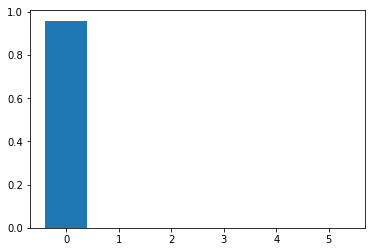

In [47]:

mnist_rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
mnist_rf_model.fit(mnist_train_encoded, mnist_train_labels_integers)

mnist_rf_test_prediction = mnist_rf_model.predict(mnist_test_encoded)
mnist_rf_acc = accuracy_score(y_pred=mnist_rf_test_prediction, y_true=mnist_test_labels_integers)
print(mnist_rf_acc)

plt.bar(np.arange(6), [mnist_rf_acc, 0,0,0,0,0])

In [48]:
mnist_train_perm.shape

(63000, 784)

In [49]:
# mnist_train_perm, mnist_test, mnist_labels_train_perm, mnist_labels_test, mnist_onehot_encoder

# mnist_labels_integermnist_onehot_encoder.inverse_transform(mnist_labels_train_perm)

mnist_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
mnist_model.fit(mnist_train_perm, mnist_train_labels_integers)

mnist_test_prediction = mnist_model.predict(mnist_test)
mnist_acc = accuracy_score(y_pred=mnist_test_prediction, y_true=mnist_test_labels_integers)
print(mnist_acc)

#plt.bar(np.arange(6), [mnist_rf_acc, 0,0,0,0,0])

0.8637142857142858


## Decitions Tree

In [51]:
mnist_dec_tree = DecisionTreeClassifier(random_state=0)
mnist_dec_tree.fit(mnist_train_encoded, mnist_train_labels_integers)
mnist_dt_test_prediction = mnist_dec_tree.predict(mnist_test_encoded)
mnist_dt_acc = accuracy_score(y_pred=mnist_dt_test_prediction, y_true=mnist_test_labels_integers)
mnist_dt_acc

0.9535714285714286

<BarContainer object of 6 artists>

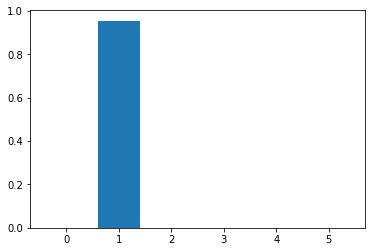

In [16]:
plt.bar(np.arange(6), [0, mnist_dt_acc,0,0,0,0])

In [52]:
mnist_orig_dt_model = DecisionTreeClassifier(random_state=0)
mnist_orig_dt_model.fit(mnist_train_perm, mnist_train_labels_integers)
mnist_orig_dt_prediction = mnist_orig_dt_model.predict(mnist_test)
mnist_orig_dt_acc = accuracy_score(y_pred=mnist_orig_dt_prediction, y_true=mnist_test_labels_integers)
mnist_orig_dt_acc

0.8851428571428571

## MNIST FF Neural Network for J=1,2,5,10,15,20,30,50,100

In [53]:
log_folder=log.get_log_folder()
print(log_folder)

tf.reset_default_graph()
simple_nn = SimpleNN(
    dims=[2, 128, 256, 512, 10],
    learning_rate=1e-3, 
    log_folder=log.get_log_folder())

simple_nn.fit(
    train_input=mnist_train_encoded, 
    train_output=mnist_labels_train_perm, 
    test_input=mnist_test_encoded, 
    test_output=mnist_labels_test,
    epochs=3)

# mnist_nn_acc = simple_nn.calculate_accuracy(data=mnist_test_encoded, labels=mnist_labels_test)
# mnist_nn_acc

/tmp/class_vae/deep/13_05_2019/20190513170904


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches = 984
Train accuracy: 98.1%
Test accuracy: 96.24%
Train accuracy: 98.08%
Test accuracy: 96.26%
Train accuracy: 98.16%
Test accuracy: 96.37%


In [57]:
mnist_from_best_exec=0.96

<BarContainer object of 6 artists>

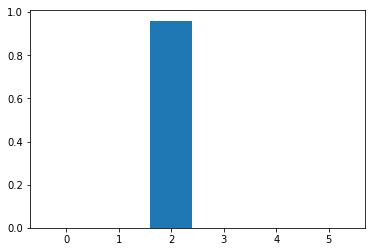

In [58]:
plt.bar(np.arange(6), [0, 0,mnist_from_best_exec,0,0,0])

## MNIST Naive Bayes Classifier 

In [54]:
mnist_nb = GaussianNB()
mnist_nb.fit(mnist_train_encoded, mnist_train_labels_integers)

mnist_nb_test_prediction = mnist_nb.predict(mnist_test_encoded)
mnist_acc_naive_bayes = accuracy_score(y_pred=mnist_nb_test_prediction, y_true=mnist_test_labels_integers)
mnist_acc_naive_bayes

0.9535714285714286

<BarContainer object of 6 artists>

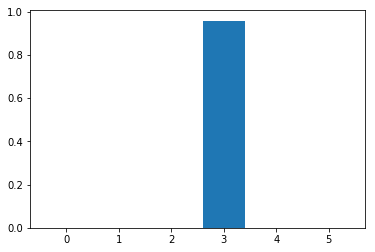

In [34]:
plt.bar(np.arange(6), [0,0,0,mnist_acc_naive_bayes,0,0])

In [55]:
# mnist_orig_nb = GaussianNB()
mnist_orig_nb = BernoulliNB()
mnist_orig_nb.fit(mnist_train_perm, mnist_train_labels_integers)

mnist_orig_nb_test_prediction = mnist_orig_nb.predict(mnist_test)
mnist_orig_acc_naive_bayes = accuracy_score(y_pred=mnist_orig_nb_test_prediction, y_true=mnist_test_labels_integers)
mnist_orig_acc_naive_bayes

0.8331428571428572

In [59]:
[mnist_rf_acc,mnist_dt_acc,mnist_from_best_exec,mnist_acc_naive_bayes]

[0.9592857142857143, 0.9535714285714286, 0.96, 0.9535714285714286]

<BarContainer object of 4 artists>

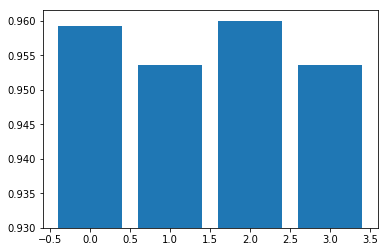

In [60]:
mnist_accs = np.array([mnist_rf_acc,mnist_dt_acc,mnist_from_best_exec,mnist_acc_naive_bayes])
mnist_accs_shifted = mnist_accs-0.93
plt.bar(np.arange(4), mnist_accs_shifted, bottom=0.93)

## Poliblog Encode data to lower dimensions 

In [147]:
# poliblog_train_encoded, poliblog_test_encoded = reduce_dimension_vae(
#     dims=dims, 
#     train_data=poliblog_data_train_perm,
#     test_data=poliblog_data_test,
#     train_labels=poliblog_ratings_train_one_hot_perm,
#     hidden_dims=[512,256,128],
#     epochs=epochs
# )


poliblog_train_encoded, poliblog_test_encoded, poliblog_train_labels_integers, poliblog_test_labels_integers = reduce_dimension_using_sup_latent(
                train_data=poliblog_data_train_perm, 
                train_labels=poliblog_ratings_train_one_hot_perm, 
                test_data=poliblog_data_test, 
                test_labels=poliblog_ratings_test_one_hot, 
                hidden_dims=[512,256,128], 
                epochs=5, 
                omega=0.5,
                mixture_assignments_train=poliblog_ratings_train_one_hot_perm,
                mixture_assignments_test=poliblog_ratings_test_one_hot,
                one_hot_encoder=poliblog_onehot_encoder
)

Starting autoencoder. Log folder=/tmp/class_vae/deep/26_05_2019/20190526114232
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 2]
self.y.shape [None, 2]
xy.shape [None, 1292]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 8
epoch: 0
Train accuracy 0.5916230082511902
Test accuracy 0.625
epoch: 1
Train accuracy 0.5916230082511902
Test accuracy 0.625
epoch: 2
Train accuracy 0.5916230082511902
Test accuracy 0.625
epoch: 3
Train accuracy 0.8027923107147217
Test accuracy 0.6499999761581421
epoch: 4
Train accuracy 0.8883071541786194
Test accuracy 0.699999988079071


In [29]:
log_folder=log.get_log_folder()
print(log_folder)

tf.reset_default_graph()
simple_nn = SimpleNN(
    dims=[1290, 512,256,128, 2],
    learning_rate=1e-3, 
    log_folder=log.get_log_folder())

simple_nn.fit(
    train_input=poliblog_data_train_perm, 
    train_output=poliblog_ratings_train_one_hot_perm, 
    test_input=poliblog_data_test, 
    test_output=poliblog_ratings_test_one_hot,
    epochs=10)

/tmp/class_vae/deep/13_05_2019/20190513170201


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches = 8
Train accuracy: 86.21%
Test accuracy: 66.5%
Train accuracy: 98.43%
Test accuracy: 71.5%
Train accuracy: 99.65%
Test accuracy: 74.5%
Train accuracy: 100.0%
Test accuracy: 73.5%
Train accuracy: 98.25%
Test accuracy: 72.0%
Train accuracy: 99.3%
Test accuracy: 69.0%
Train accuracy: 100.0%
Test accuracy: 73.5%
Train accuracy: 99.48%
Test accuracy: 70.5%
Train accuracy: 100.0%
Test accuracy: 72.5%
Train accuracy: 100.0%
Test accuracy: 73.0%


## poliblog random forest

0.71


<BarContainer object of 4 artists>

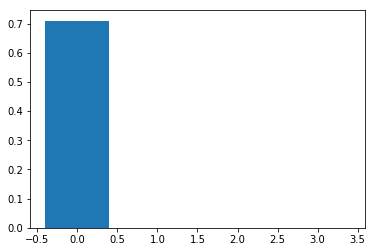

In [30]:

poliblog_rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
poliblog_rf_model.fit(poliblog_train_encoded, poliblog_train_labels_integers)

poliblog_rf_test_prediction = poliblog_rf_model.predict(poliblog_test_encoded)
poliblog_rf_acc = accuracy_score(y_pred=poliblog_rf_test_prediction, y_true=poliblog_test_labels_integers)
print(poliblog_rf_acc)

plt.bar(np.arange(4), [poliblog_rf_acc, 0,0,0])




# poliblog_rf_models = train_rf_reduced_space(dims, poliblog_train_encoded, poliblog_train_labels_integers)
# poliblog_accs_rf = analyse_reduced_space(dims, poliblog_rf_models, poliblog_test_encoded, poliblog_test_labels_integers)
# plt.plot(dims, poliblog_accs_rf)

## poliblog decision tree

0.69


<BarContainer object of 4 artists>

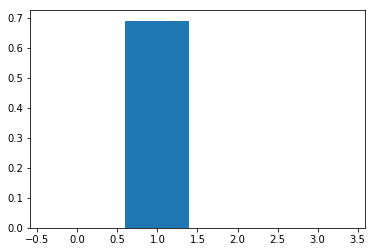

In [32]:
# poliblog_decision_tree_models = train_decision_tree_reduced_space(dims, poliblog_train_encoded, poliblog_ratings_train_one_hot_perm)
# poliblog_accs_decision_tree = analyse_reduced_space(dims, poliblog_decision_tree_models, poliblog_test_encoded, poliblog_ratings_test_one_hot)
# plt.plot(dims, poliblog_accs_decision_tree)


poliblog_dec_tree = DecisionTreeClassifier(random_state=0)
poliblog_dec_tree.fit(poliblog_train_encoded, poliblog_train_labels_integers)
poliblog_dt_test_prediction = poliblog_dec_tree.predict(poliblog_test_encoded)
poliblog_dt_acc = accuracy_score(y_pred=poliblog_dt_test_prediction, y_true=poliblog_test_labels_integers)
print(poliblog_dt_acc)

plt.bar(np.arange(4), [0, poliblog_dt_acc,0,0])


## poliblog nn

In [36]:
log_folder=log.get_log_folder()
print(log_folder)

tf.reset_default_graph()
simple_nn = SimpleNN(
    dims=[2, 128, 256, 512, 2],
    learning_rate=1e-3, 
    log_folder=log.get_log_folder())

simple_nn.fit(
    train_input=poliblog_train_encoded, 
    train_output=poliblog_ratings_train_one_hot_perm, 
    test_input=poliblog_test_encoded, 
    test_output=poliblog_ratings_test_one_hot,
    epochs=3)

# poliblog_nn_acc = simple_nn.calculate_accuracy(data=poliblog_test_encoded, labels=poliblog_labels_test)
# poliblog_nn_acc

/tmp/class_vae/deep/13_05_2019/20190513170252
n_batches = 8
Train accuracy: 99.65%
Test accuracy: 68.0%
Train accuracy: 99.65%
Test accuracy: 67.0%
Train accuracy: 99.48%
Test accuracy: 69.0%


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


<BarContainer object of 4 artists>

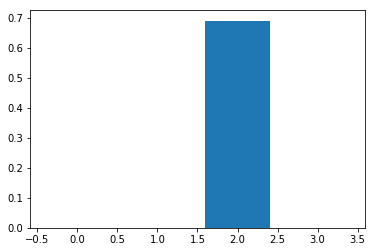

In [37]:
poliblog_nn_acc=0.69
plt.bar(np.arange(4), [0, 0,poliblog_nn_acc,0])


## Poliblog naive bayes

0.705


<BarContainer object of 4 artists>

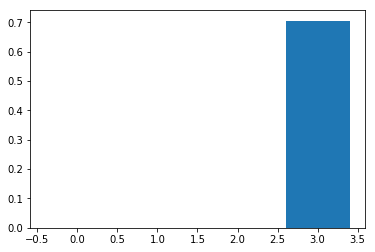

In [39]:
# poliblog_train_labels_integers = poliblog_onehot_encoder.inverse_transform(poliblog_ratings_train_one_hot_perm).reshape(-1)
# poliblog_test_labels_integers = poliblog_onehot_encoder.inverse_transform(poliblog_ratings_test_one_hot).reshape(-1)
# poliblog_train_labels_integers.shape,poliblog_test_labels_integers.shape

# poliblog_naive_bayes_models = train_naive_bayes_reduced_space(dims, poliblog_train_encoded, poliblog_train_labels_integers)
# poliblog_accs_naive_bayes = analyse_reduced_space(dims, poliblog_naive_bayes_models, poliblog_test_encoded, poliblog_test_labels_integers)
# plt.plot(dims, poliblog_accs_naive_bayes)

poliblog_nb = GaussianNB()
poliblog_nb.fit(poliblog_train_encoded, poliblog_train_labels_integers)

poliblog_nb_test_prediction = poliblog_nb.predict(poliblog_test_encoded)
poliblog_acc_naive_bayes = accuracy_score(y_pred=poliblog_nb_test_prediction, y_true=poliblog_test_labels_integers)
print(poliblog_acc_naive_bayes)

plt.bar(np.arange(4), [0, 0,0,poliblog_acc_naive_bayes])



In [40]:
poliblog_acc_naive_bayes

0.705

<BarContainer object of 4 artists>

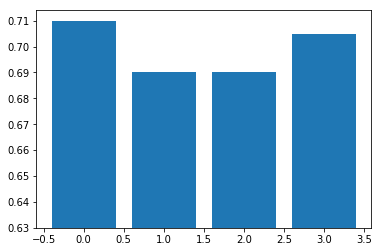

In [41]:
poliblog_accs=np.array([poliblog_rf_acc,poliblog_dt_acc,poliblog_nn_acc,poliblog_acc_naive_bayes])
poliblog_accs_shifted = poliblog_accs-0.63
plt.bar(np.arange(4), poliblog_accs_shifted, bottom=0.63)

In [42]:
poliblog_accs

array([0.71 , 0.69 , 0.69 , 0.705])

In [43]:
ind=np.arange(4)
width=0.35
plt.bar(ind, mnist_accs, width, label='MNIST')
plt.bar(ind + width, poliblog_accs, width, label='Poliblog')


plt.show()

NameError: name 'mnist_accs' is not defined

## SmsSpam data reduced to J=1,2,5,10,15,20,30,50,100

In [61]:
log_folder=log.get_log_folder()
print(log_folder)

tf.reset_default_graph()
simple_nn = SimpleNN(
    dims=[16, 512,256,128, 2],
    learning_rate=1e-3, 
    log_folder=log.get_log_folder())

simple_nn.fit(
    train_input=smsSpam_data_train_perm, 
    train_output=smsSpam_labels_train_one_hot_perm, 
    test_input=smsSpam_data_test, 
    test_output=smsSpam_labels_test_one_hot,
    epochs=10)

/tmp/class_vae/deep/13_05_2019/20190513171014


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches = 11
Train accuracy: 76.82%
Test accuracy: 73.5%
Train accuracy: 87.2%
Test accuracy: 83.5%
Train accuracy: 89.76%
Test accuracy: 87.0%
Train accuracy: 89.62%
Test accuracy: 87.0%
Train accuracy: 90.43%
Test accuracy: 88.5%
Train accuracy: 90.84%
Test accuracy: 88.5%
Train accuracy: 91.11%
Test accuracy: 90.0%
Train accuracy: 91.37%
Test accuracy: 89.0%
Train accuracy: 91.11%
Test accuracy: 89.5%
Train accuracy: 91.51%
Test accuracy: 90.0%


In [62]:
# smsspam_train_encoded, smsspam_test_encoded = reduce_dimension_vae(
#     dims=dims, 
#     train_data=smsSpam_data_train_perm,
#     test_data=smsSpam_data_test,
#     train_labels=smsSpam_labels_train_one_hot_perm,
#     hidden_dims=[512,256,128],
#     epochs=epochs
# )

smsspam_train_encoded, smsspam_test_encoded, smsSpam_train_labels_integers, smsSpam_test_labels_integers = reduce_dimension_using_sup_latent(
                train_data=smsSpam_data_train_perm, 
                train_labels=smsSpam_labels_train_one_hot_perm, 
                test_data=smsSpam_data_test, 
                test_labels=smsSpam_labels_test_one_hot, 
                hidden_dims=[512,256,128], 
                epochs=10, 
                omega=0.5,
                mixture_assignments_train=smsSpam_labels_train_one_hot_perm,
                mixture_assignments_test=smsSpam_labels_test_one_hot,
                one_hot_encoder=smsSpam_onehot_encoder
)

Starting autoencoder. Log folder=/tmp/class_vae/deep/13_05_2019/20190513171017
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 2]
self.y.shape [None, 2]
xy.shape [None, 18]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 11
epoch: 0
Train accuracy 0.7250673770904541
Test accuracy 0.7099999785423279
epoch: 1
Train accuracy 0.7587600946426392
Test accuracy 0.7300000190734863
epoch: 2
Train accuracy 0.8032345175743103
Test accuracy 0.7599999904632568
epoch: 3
Train accuracy 0.8140161633491516
Test accuracy 0.824999988079071
epoch: 4
Train accuracy 0.8396226167678833
Test accuracy 0.8149999976158142
epoch: 5
Train accuracy 0.8261455297470093
Test accuracy 0.8299999833106995
epoch: 6
Train accuracy 0.8517520427703857
Test accuracy 0.8500000238418579
epoch: 7
Train accuracy 0.8517520427703857
Test accuracy 0.8450000286102295
epoch: 8
Train accuracy 0.8652291297912598
Test accuracy 0.8700000047683716
epoch: 9
Train accuracy 0.8854447603225708
Test accuracy 0.8600000143051147


## SmsSpam Random Forest

0.85


<BarContainer object of 4 artists>

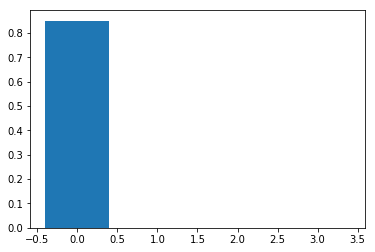

In [63]:
# smsspam_rf_models = train_rf_reduced_space(dims, smsspam_train_encoded, smsSpam_labels_train_one_hot_perm)
# smsspam_accs_rf = analyse_reduced_space(dims, smsspam_rf_models, smsspam_test_encoded, smsSpam_labels_test_one_hot)
# plt.plot(dims, smsspam_accs_rf)

smsSpam_rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
smsSpam_rf_model.fit(smsspam_train_encoded, smsSpam_train_labels_integers)

smsSpam_rf_test_prediction = smsSpam_rf_model.predict(smsspam_test_encoded)
smsSpam_rf_acc = accuracy_score(y_pred=smsSpam_rf_test_prediction, y_true=smsSpam_test_labels_integers)
print(smsSpam_rf_acc)

plt.bar(np.arange(4), [smsSpam_rf_acc, 0,0,0])

## SmsSpam Decision Tree

<BarContainer object of 4 artists>

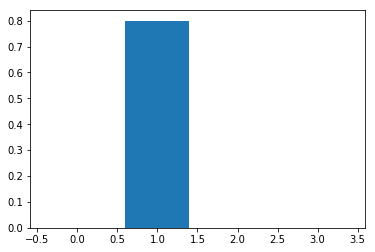

In [64]:
# smsspam_decision_tree_models = train_decision_tree_reduced_space(dims, smsspam_train_encoded, smsSpam_labels_train_one_hot_perm)
# smsspam_accs_decision_tree = analyse_reduced_space(dims, smsspam_decision_tree_models, smsspam_test_encoded, smsSpam_labels_test_one_hot)
# plt.plot(dims, smsspam_accs_decision_tree)

smsSpam_train_encoded=smsspam_train_encoded
smsSpam_test_encoded=smsspam_test_encoded

smsSpam_dec_tree = DecisionTreeClassifier(random_state=0)
smsSpam_dec_tree.fit(smsSpam_train_encoded, smsSpam_train_labels_integers)
smsSpam_dt_test_prediction = smsSpam_dec_tree.predict(smsSpam_test_encoded)
smsSpam_dt_acc = accuracy_score(y_pred=smsSpam_dt_test_prediction, y_true=smsSpam_test_labels_integers)
smsSpam_dt_acc

plt.bar(np.arange(4), [0, smsSpam_dt_acc,0,0])



In [65]:
np.max(smsSpam_dt_acc)

0.8

## FF NN

In [66]:
# nn_smsspam_accuracies = train_and_analyse_simple_nn_reduced_space(
#     dims=dims, 
#     train_encoded=smsspam_train_encoded, 
#     train_labels=smsSpam_labels_train_one_hot_perm, 
#     test_encoded=smsspam_test_encoded, 
#     test_labels=smsSpam_labels_test_one_hot, 
#     epochs=5
# )

log_folder=log.get_log_folder()
print(log_folder)

tf.reset_default_graph()
simple_nn = SimpleNN(
    dims=[2, 128, 256, 512, 2],
    learning_rate=1e-3, 
    log_folder=log.get_log_folder())

simple_nn.fit(
    train_input=smsSpam_train_encoded, 
    train_output=smsSpam_labels_train_one_hot_perm, 
    test_input=smsSpam_test_encoded, 
    test_output=smsSpam_labels_test_one_hot,
    epochs=10)

# smsSpam_nn_acc = simple_nn.calculate_accuracy(data=smsSpam_test_encoded, labels=smsSpam_labels_test)
# smsSpam_nn_acc

/tmp/class_vae/deep/13_05_2019/20190513171037


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches = 11
Train accuracy: 87.6%
Test accuracy: 86.5%
Train accuracy: 88.27%
Test accuracy: 84.0%
Train accuracy: 88.01%
Test accuracy: 86.0%
Train accuracy: 87.6%
Test accuracy: 85.5%
Train accuracy: 88.01%
Test accuracy: 85.0%
Train accuracy: 88.01%
Test accuracy: 85.5%
Train accuracy: 87.6%
Test accuracy: 85.5%
Train accuracy: 88.54%
Test accuracy: 85.0%
Train accuracy: 87.6%
Test accuracy: 85.5%
Train accuracy: 88.41%
Test accuracy: 85.0%


## Naive Bayes

<BarContainer object of 4 artists>

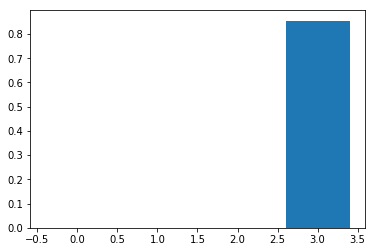

In [67]:
smsSpam_nb = GaussianNB()
smsSpam_nb.fit(smsSpam_train_encoded, smsSpam_train_labels_integers)

smsSpam_nb_test_prediction = smsSpam_nb.predict(smsSpam_test_encoded)
smsSpam_acc_naive_bayes = accuracy_score(y_pred=smsSpam_nb_test_prediction, y_true=smsSpam_test_labels_integers)
smsSpam_acc_naive_bayes

plt.bar(np.arange(4), [0, 0,0,smsSpam_acc_naive_bayes])

In [68]:
np.max(smsSpam_acc_naive_bayes)

0.855

In [69]:
smsSpam_acc_dslgmm = [0.87,0.795,0.87,0.88, 0.879]

## Reuters2 reduce dim

In [70]:
log_folder=log.get_log_folder()
print(log_folder)

tf.reset_default_graph()
simple_nn = SimpleNN(
    dims=[2000, 512,256,128, 2],
    learning_rate=1e-3, 
    log_folder=log.get_log_folder())

simple_nn.fit(
    train_input=reuters2_data_train_perm, 
    train_output=reuters2_labels_train_one_hot_perm, 
    test_input=reuters2_data_test, 
    test_output=reuters2_labels_test_one_hot,
    epochs=10)

/tmp/class_vae/deep/13_05_2019/20190513171044


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches = 16
Train accuracy: 99.72%
Test accuracy: 96.05%
Train accuracy: 100.0%
Test accuracy: 96.47%
Train accuracy: 100.0%
Test accuracy: 96.05%
Train accuracy: 100.0%
Test accuracy: 96.05%
Train accuracy: 100.0%
Test accuracy: 96.05%
Train accuracy: 100.0%
Test accuracy: 96.05%
Train accuracy: 100.0%
Test accuracy: 96.61%
Train accuracy: 100.0%
Test accuracy: 96.61%
Train accuracy: 100.0%
Test accuracy: 96.89%
Train accuracy: 100.0%
Test accuracy: 97.18%


In [71]:
reuters2_train_encoded, reuters2_test_encoded, reuters2_train_labels_integers, reuters2_test_labels_integers = reduce_dimension_using_sup_latent(
                train_data=reuters2_data_train_perm, 
                train_labels=reuters2_labels_train_one_hot_perm, 
                test_data=reuters2_data_test, 
                test_labels=reuters2_labels_test_one_hot, 
                hidden_dims=[512,256,128], 
                epochs=10, 
                omega=0.5,
                mixture_assignments_train=reuters2_labels_train_one_hot_perm,
                mixture_assignments_test=reuters2_labels_test_one_hot,
                one_hot_encoder=reuters2_onehot_encoder
)

Starting autoencoder. Log folder=/tmp/class_vae/deep/13_05_2019/20190513171048
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 2]
self.y.shape [None, 2]
xy.shape [None, 2002]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 16
epoch: 0
Train accuracy 0.7612782120704651
Test accuracy 0.7146892547607422
epoch: 1
Train accuracy 0.8515037298202515
Test accuracy 0.7711864113807678
epoch: 2
Train accuracy 0.9436089992523193
Test accuracy 0.854519784450531
epoch: 3
Train accuracy 0.9680451154708862
Test accuracy 0.8700565099716187
epoch: 4
Train accuracy 0.9708646535873413
Test accuracy 0.8898305296897888
epoch: 5
Train accuracy 0.99154132604599
Test accuracy 0.8983050584793091
epoch: 6
Train accuracy 0.9962406158447266
Test accuracy 0.9110169410705566
epoch: 7
Train accuracy 0.9924812316894531
Test accuracy 0.9265536665916443
epoch: 8
Train accuracy 0.9971804618835449
Test accuracy 0.9180790781974792
epoch: 9
Train accuracy 0.9943609237670898
Test accuracy 0.9223163723945618


## reuters2 Random Forest

0.9194915254237288


<BarContainer object of 4 artists>

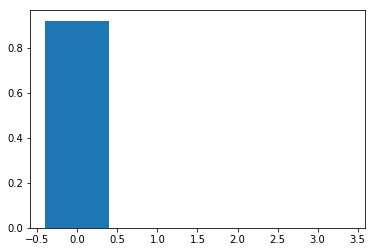

In [72]:
reuters2_rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
reuters2_rf_model.fit(reuters2_train_encoded, reuters2_train_labels_integers)

reuters2_rf_test_prediction = reuters2_rf_model.predict(reuters2_test_encoded)
reuters2_rf_acc = accuracy_score(y_pred=reuters2_rf_test_prediction, y_true=reuters2_test_labels_integers)
print(reuters2_rf_acc)

plt.bar(np.arange(4), [reuters2_rf_acc, 0,0,0])

## reuters2 decision tree

<BarContainer object of 4 artists>

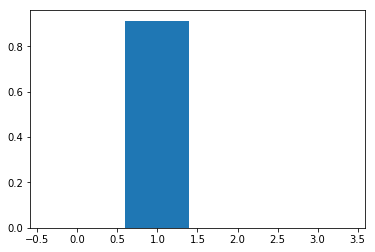

In [73]:
reuters2_train_encoded=reuters2_train_encoded
reuters2_test_encoded=reuters2_test_encoded

reuters2_dec_tree = DecisionTreeClassifier(random_state=0)
reuters2_dec_tree.fit(reuters2_train_encoded, reuters2_train_labels_integers)
reuters2_dt_test_prediction = reuters2_dec_tree.predict(reuters2_test_encoded)
reuters2_dt_acc = accuracy_score(y_pred=reuters2_dt_test_prediction, y_true=reuters2_test_labels_integers)
reuters2_dt_acc

plt.bar(np.arange(4), [0, reuters2_dt_acc,0,0])

In [74]:
np.max(reuters2_dt_acc)

0.9124293785310734

## FF NN

In [75]:
log_folder=log.get_log_folder()
print(log_folder)

tf.reset_default_graph()
simple_nn = SimpleNN(
    dims=[2, 128, 256, 512, 2],
    learning_rate=1e-3, 
    log_folder=log.get_log_folder())

simple_nn.fit(
    train_input=reuters2_train_encoded, 
    train_output=reuters2_labels_train_one_hot_perm, 
    test_input=reuters2_test_encoded, 
    test_output=reuters2_labels_test_one_hot,
    epochs=10)

/tmp/class_vae/deep/13_05_2019/20190513171058


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches = 16
Train accuracy: 99.62%
Test accuracy: 91.38%
Train accuracy: 99.72%
Test accuracy: 92.37%
Train accuracy: 99.62%
Test accuracy: 91.38%
Train accuracy: 99.72%
Test accuracy: 91.67%
Train accuracy: 99.81%
Test accuracy: 91.67%
Train accuracy: 99.81%
Test accuracy: 91.38%
Train accuracy: 99.81%
Test accuracy: 91.24%
Train accuracy: 99.81%
Test accuracy: 90.68%
Train accuracy: 99.81%
Test accuracy: 91.1%
Train accuracy: 99.72%
Test accuracy: 91.1%


## reuters2 Naive Bayes

<BarContainer object of 4 artists>

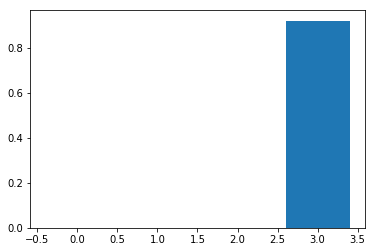

In [76]:
reuters2_nb = GaussianNB()
reuters2_nb.fit(reuters2_train_encoded, reuters2_train_labels_integers)

reuters2_nb_test_prediction = reuters2_nb.predict(reuters2_test_encoded)
reuters2_acc_naive_bayes = accuracy_score(y_pred=reuters2_nb_test_prediction, y_true=reuters2_test_labels_integers)
reuters2_acc_naive_bayes

plt.bar(np.arange(4), [0, 0,0,reuters2_acc_naive_bayes])

In [77]:
np.max(reuters2_acc_naive_bayes)

0.9194915254237288

## reuters3 reduce dim

In [78]:
log_folder=log.get_log_folder()
print(log_folder)

tf.reset_default_graph()
simple_nn = SimpleNN(
    dims=[2000, 512,256,128, 3],
    learning_rate=1e-3, 
    log_folder=log.get_log_folder())

simple_nn.fit(
    train_input=reuters3_data_train_perm, 
    train_output=reuters3_labels_train_one_hot_perm, 
    test_input=reuters3_data_test, 
    test_output=reuters3_labels_test_one_hot,
    epochs=10)

/tmp/class_vae/deep/13_05_2019/20190513171104


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches = 25
Train accuracy: 96.13%
Test accuracy: 84.85%
Train accuracy: 98.91%
Test accuracy: 85.75%
Train accuracy: 99.7%
Test accuracy: 86.84%
Train accuracy: 99.82%
Test accuracy: 86.48%
Train accuracy: 99.88%
Test accuracy: 85.93%
Train accuracy: 99.88%
Test accuracy: 86.57%
Train accuracy: 99.94%
Test accuracy: 85.75%
Train accuracy: 99.94%
Test accuracy: 86.93%
Train accuracy: 99.94%
Test accuracy: 86.84%
Train accuracy: 99.94%
Test accuracy: 86.3%


In [79]:
reuters3_train_encoded, reuters3_test_encoded, reuters3_train_labels_integers, reuters3_test_labels_integers = reduce_dimension_using_sup_latent(
                train_data=reuters3_data_train_perm, 
                train_labels=reuters3_labels_train_one_hot_perm, 
                test_data=reuters3_data_test, 
                test_labels=reuters3_labels_test_one_hot, 
                hidden_dims=[512,256,128], 
                epochs=20, 
                omega=0.5,
                mixture_assignments_train=reuters3_labels_train_one_hot_perm,
                mixture_assignments_test=reuters3_labels_test_one_hot,
                one_hot_encoder=reuters3_onehot_encoder
)

Starting autoencoder. Log folder=/tmp/class_vae/deep/13_05_2019/20190513171108
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 3]
self.y.shape [None, 3]
xy.shape [None, 2003]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 25
epoch: 0
Train accuracy 0.5546827912330627
Test accuracy 0.4954628050327301
epoch: 1
Train accuracy 0.7655588984489441
Test accuracy 0.6197822093963623
epoch: 2
Train accuracy 0.8749244809150696
Test accuracy 0.6814882159233093
epoch: 3
Train accuracy 0.9577039480209351
Test accuracy 0.7513611912727356
epoch: 4
Train accuracy 0.9794561862945557
Test accuracy 0.7731397747993469
epoch: 5
Train accuracy 0.9873111844062805
Test accuracy 0.786751389503479
epoch: 6
Train accuracy 0.9945619106292725
Test accuracy 0.7921960353851318
epoch: 7
Train accuracy 0.9975830912590027
Test accuracy 0.7976406812667847
epoch: 8
Train accuracy 0.9957703948020935
Test accuracy 0.7967332005500793
epoch: 9
Train accuracy 1.0
Test accuracy 0.8121597170829773
epoch: 10
Train accuracy 0.9981873035430908
Test accuracy 0.8049001693725586
epoch: 11
Train accuracy 1.0
Test accuracy 0.8085299730300903
epoch: 12
Train accuracy 0.998791515827179
Test accuracy 0.807622492313385
epoch: 13
Train accuracy 0.9

## reuters3 Random Forest

0.8012704174228675


<BarContainer object of 4 artists>

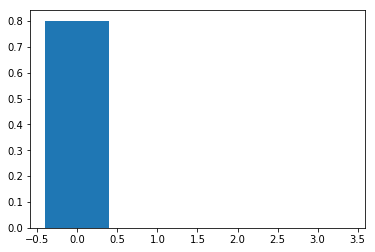

In [80]:
reuters3_rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
reuters3_rf_model.fit(reuters3_train_encoded, reuters3_train_labels_integers)

reuters3_rf_test_prediction = reuters3_rf_model.predict(reuters3_test_encoded)
reuters3_rf_acc = accuracy_score(y_pred=reuters3_rf_test_prediction, y_true=reuters3_test_labels_integers)
print(reuters3_rf_acc)

plt.bar(np.arange(4), [reuters3_rf_acc, 0,0,0])

## reuters3 decision tree

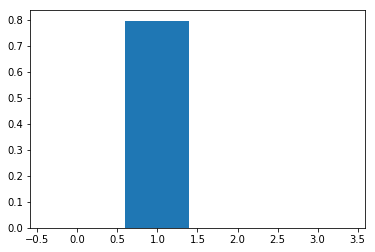

0.7967332123411979

In [81]:
reuters3_train_encoded=reuters3_train_encoded
reuters3_test_encoded=reuters3_test_encoded

reuters3_dec_tree = DecisionTreeClassifier(random_state=0)
reuters3_dec_tree.fit(reuters3_train_encoded, reuters3_train_labels_integers)
reuters3_dt_test_prediction = reuters3_dec_tree.predict(reuters3_test_encoded)
reuters3_dt_acc = accuracy_score(y_pred=reuters3_dt_test_prediction, y_true=reuters3_test_labels_integers)
reuters3_dt_acc

plt.bar(np.arange(4), [0, reuters3_dt_acc,0,0])
plt.show()
np.max(reuters3_dt_acc)

In [82]:
np.max(reuters3_dt_acc)

0.7967332123411979

## FF NN

In [83]:
log_folder=log.get_log_folder()
print(log_folder)

tf.reset_default_graph()
simple_nn = SimpleNN(
    dims=[2, 128, 256, 512, 3],
    learning_rate=1e-3, 
    log_folder=log.get_log_folder())

simple_nn.fit(
    train_input=reuters3_train_encoded, 
    train_output=reuters3_labels_train_one_hot_perm, 
    test_input=reuters3_test_encoded, 
    test_output=reuters3_labels_test_one_hot,
    epochs=10)

/tmp/class_vae/deep/13_05_2019/20190513171133


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches = 25
Train accuracy: 99.94%
Test accuracy: 82.4%
Train accuracy: 99.94%
Test accuracy: 82.49%
Train accuracy: 99.88%
Test accuracy: 82.4%
Train accuracy: 99.94%
Test accuracy: 82.21%
Train accuracy: 99.94%
Test accuracy: 82.21%
Train accuracy: 99.94%
Test accuracy: 82.49%
Train accuracy: 99.88%
Test accuracy: 82.3%
Train accuracy: 99.94%
Test accuracy: 81.85%
Train accuracy: 99.94%
Test accuracy: 82.21%
Train accuracy: 99.88%
Test accuracy: 81.85%


## Naive Bayes

<BarContainer object of 4 artists>

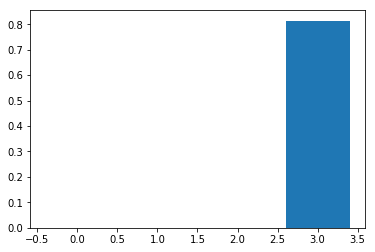

In [84]:
reuters3_nb = GaussianNB()
reuters3_nb.fit(reuters3_train_encoded, reuters3_train_labels_integers)

reuters3_nb_test_prediction = reuters3_nb.predict(reuters3_test_encoded)
reuters3_acc_naive_bayes = accuracy_score(y_pred=reuters3_nb_test_prediction, y_true=reuters3_test_labels_integers)
reuters3_acc_naive_bayes

plt.bar(np.arange(4), [0, 0,0,reuters3_acc_naive_bayes])

In [85]:
np.max(reuters3_acc_naive_bayes)

0.8139745916515426

## reuters5 reduce dim

In [86]:
log_folder=log.get_log_folder()
print(log_folder)

tf.reset_default_graph()
simple_nn = SimpleNN(
    dims=[2000, 512,256,128, 5],
    learning_rate=1e-3, 
    log_folder=log.get_log_folder())

simple_nn.fit(
    train_input=reuters5_data_train_perm, 
    train_output=reuters5_labels_train_one_hot_perm, 
    test_input=reuters5_data_test, 
    test_output=reuters5_labels_test_one_hot,
    epochs=10)

/tmp/class_vae/deep/13_05_2019/20190513171140


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches = 44
Train accuracy: 88.59%
Test accuracy: 75.04%
Train accuracy: 98.72%
Test accuracy: 77.22%
Train accuracy: 99.79%
Test accuracy: 77.86%
Train accuracy: 99.86%
Test accuracy: 76.53%
Train accuracy: 99.89%
Test accuracy: 76.1%
Train accuracy: 99.93%
Test accuracy: 77.49%
Train accuracy: 99.93%
Test accuracy: 75.78%
Train accuracy: 99.96%
Test accuracy: 77.54%
Train accuracy: 99.96%
Test accuracy: 76.9%
Train accuracy: 100.0%
Test accuracy: 77.54%


In [87]:
reuters5_train_encoded, reuters5_test_encoded, reuters5_train_labels_integers, reuters5_test_labels_integers = reduce_dimension_using_sup_latent(
                train_data=reuters5_data_train_perm, 
                train_labels=reuters5_labels_train_one_hot_perm, 
                test_data=reuters5_data_test, 
                test_labels=reuters5_labels_test_one_hot, 
                hidden_dims=[512,256,128], 
                epochs=20, 
                omega=0.5,
                mixture_assignments_train=reuters5_labels_train_one_hot_perm,
                mixture_assignments_test=reuters5_labels_test_one_hot,
                one_hot_encoder=reuters5_onehot_encoder
)

Starting autoencoder. Log folder=/tmp/class_vae/deep/13_05_2019/20190513171145
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 5]
self.y.shape [None, 5]
xy.shape [None, 2005]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 44
epoch: 0
Train accuracy 0.3425433933734894
Test accuracy 0.3038850426673889
epoch: 1
Train accuracy 0.5593340396881104
Test accuracy 0.4119212329387665
epoch: 2
Train accuracy 0.8558271527290344
Test accuracy 0.6045768857002258
epoch: 3
Train accuracy 0.935175359249115
Test accuracy 0.6716338396072388
epoch: 4
Train accuracy 0.9798086881637573
Test accuracy 0.6918573975563049
epoch: 5
Train accuracy 0.9883103370666504
Test accuracy 0.684406578540802
epoch: 6
Train accuracy 0.9943322539329529
Test accuracy 0.7147418856620789
epoch: 7
Train accuracy 0.997520387172699
Test accuracy 0.7035657167434692
epoch: 8
Train accuracy 0.997520387172699
Test accuracy 0.7147418856620789
epoch: 9
Train accuracy 0.9985830783843994
Test accuracy 0.7168706655502319
epoch: 10
Train accuracy 0.9982288479804993
Test accuracy 0.7136774659156799
epoch: 11
Train accuracy 0.9989373087882996
Test accuracy 0.7168706655502319
epoch: 12
Train accuracy 0.9985830783843994
Test accuracy 0.7110164761543274

## reuters5 random forest

0.672166045769026


<BarContainer object of 4 artists>

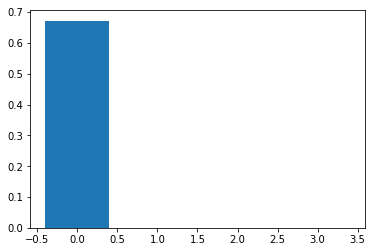

In [88]:
reuters5_rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
reuters5_rf_model.fit(reuters5_train_encoded, reuters5_train_labels_integers)

reuters5_rf_test_prediction = reuters5_rf_model.predict(reuters5_test_encoded)
reuters5_rf_acc = accuracy_score(y_pred=reuters5_rf_test_prediction, y_true=reuters5_test_labels_integers)
print(reuters5_rf_acc)

plt.bar(np.arange(4), [reuters5_rf_acc, 0,0,0])

## reuters5 decision tree

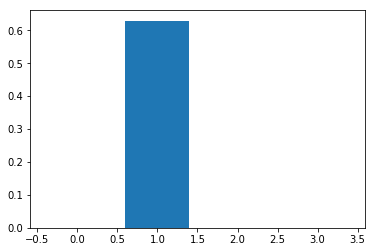

0.6290580095795636

In [89]:
reuters5_train_encoded=reuters5_train_encoded
reuters5_test_encoded=reuters5_test_encoded

reuters5_dec_tree = DecisionTreeClassifier(random_state=0)
reuters5_dec_tree.fit(reuters5_train_encoded, reuters5_train_labels_integers)
reuters5_dt_test_prediction = reuters5_dec_tree.predict(reuters5_test_encoded)
reuters5_dt_acc = accuracy_score(y_pred=reuters5_dt_test_prediction, y_true=reuters5_test_labels_integers)
reuters5_dt_acc

plt.bar(np.arange(4), [0, reuters5_dt_acc,0,0])
plt.show()
np.max(reuters5_dt_acc)

## FF NN

In [90]:
log_folder=log.get_log_folder()
print(log_folder)

tf.reset_default_graph()
simple_nn = SimpleNN(
    dims=[2, 128, 256, 512, 5],
    learning_rate=1e-3, 
    log_folder=log.get_log_folder())

simple_nn.fit(
    train_input=reuters5_train_encoded, 
    train_output=reuters5_labels_train_one_hot_perm, 
    test_input=reuters5_test_encoded, 
    test_output=reuters5_labels_test_one_hot,
    epochs=10)

/tmp/class_vae/deep/13_05_2019/20190513171212


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches = 44
Train accuracy: 99.89%
Test accuracy: 71.37%
Train accuracy: 99.89%
Test accuracy: 71.53%
Train accuracy: 99.89%
Test accuracy: 71.9%
Train accuracy: 99.89%
Test accuracy: 72.06%
Train accuracy: 99.89%
Test accuracy: 72.01%
Train accuracy: 99.93%
Test accuracy: 71.79%
Train accuracy: 99.93%
Test accuracy: 69.98%
Train accuracy: 99.93%
Test accuracy: 70.89%
Train accuracy: 99.93%
Test accuracy: 70.3%
Train accuracy: 99.93%
Test accuracy: 71.37%


## Naive Bayes

<BarContainer object of 4 artists>

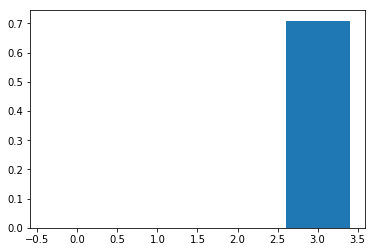

In [91]:
reuters5_nb = GaussianNB()
reuters5_nb.fit(reuters5_train_encoded, reuters5_train_labels_integers)

reuters5_nb_test_prediction = reuters5_nb.predict(reuters5_test_encoded)
reuters5_acc_naive_bayes = accuracy_score(y_pred=reuters5_nb_test_prediction, y_true=reuters5_test_labels_integers)
reuters5_acc_naive_bayes

plt.bar(np.arange(4), [0, 0,0,reuters5_acc_naive_bayes])

In [92]:
np.max(reuters5_acc_naive_bayes)

0.7088877062267164

In [ ]:
nn_mnist_accuracies_vae=[0.32342857,
 0.40071428,
 0.664,
 0.7482857,
 0.85385716,
 0.7591429,
 0.9317143,
 0.928,
 0.7664286]

In [ ]:
poliblog_accs_rf_vae=[0.625, 0.6, 0.615, 0.6, 0.635, 0.63, 0.595, 0.585, 0.605]

In [ ]:
smsspam_accs_rf_vae=[0.705, 0.71, 0.72, 0.71, 0.71, 0.71, 0.705, 0.71, 0.71]

In [ ]:
reuters2_accs_rf_vae=[0.6271186440677966,
 0.6624293785310734,
 0.6073446327683616,
 0.5805084745762712,
 0.6087570621468926,
 0.6115819209039548,
 0.6045197740112994,
 0.5932203389830508,
 0.5649717514124294]

In [ ]:
reuters3_accs_rf_vae=[0.4382940108892922,
 0.4455535390199637,
 0.43284936479128855,
 0.41742286751361163,
 0.4029038112522686,
 0.39473684210526316,
 0.42014519056261346,
 0.40381125226860254,
 0.3911070780399274]

In [ ]:
reuters5_accs_rf_vae=[0.23789249600851517,
 0.2655667908461948,
 0.24108568387440127,
 0.26450239489089944,
 0.22778073443320915,
 0.23097392229909527,
 0.2293773283661522,
 0.21128259712613093,
 0.2197977647684939]

In [ ]:
fig = plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)

plt.subplot(3, 2, 1)
plt.plot(dims, mnist_accs_rf, label='Random Forest')
plt.plot(dims, mnist_accs_decision_tree, label='Decision Tree')
plt.plot(dims, nn_mnist_accuracies, label='FF Neural Network') 
plt.plot(dims, mnist_accs_naive_bayes, label='Naive Bayes') 
plt.plot(dims, nn_mnist_accuracies_vae, '--', label='FF Neural Network for VAE') 


plt.title("Combined results for classification of reduced mnist data")
plt.xlabel("Dimensionality (Number of features)")
plt.ylabel("Accuracy")
plt.legend(loc='best')

plt.subplot(3, 2, 2)
plt.plot(dims, poliblog_accs_rf, label='Random Forest')
plt.plot(dims, poliblog_accs_decision_tree, label='Decision Tree')
plt.plot(dims, nn_poliblog_accuracies, label='FF Neural Network') 
plt.plot(dims, poliblog_accs_naive_bayes, label='Naive Bayes') 
plt.plot(dims, poliblog_accs_rf_vae, '--', label='Random Forest for VAE')


plt.title("Combined results for classification of reduced poliblog data")
plt.xlabel("Dimensionality (Number of features)")
plt.ylabel("Accuracy")
plt.legend(loc='best')

plt.subplot(3, 2, 3)
plt.plot(dims, smsspam_accs_rf, label='Random Forest')
plt.plot(dims, smsspam_accs_decision_tree, label='Decision Tree')
plt.plot(dims, nn_smsspam_accuracies, label='FF Neural Network') 
plt.plot(dims, smsspam_accs_naive_bayes, label='Naive Bayes') 
plt.plot(dims, smsspam_accs_rf_vae, '--',label='Random Forest for VAE')


plt.title("Combined results for classification of reduced smsSpam data")
plt.xlabel("Dimensionality (Number of features)")
plt.ylabel("Accuracy")
plt.legend(loc='best')

plt.subplot(3, 2, 4)
plt.plot(dims, reuters2_accs_rf, label='Random Forest')
plt.plot(dims, reuters2_accs_decision_tree, label='Decision Tree')
plt.plot(dims, nn_reuters2_accuracies, label='FF Neural Network') 
plt.plot(dims, reuters2_accs_naive_bayes, label='Naive Bayes')
plt.plot(dims, reuters2_accs_rf_vae, '--', label='Random Forest for VAE')

plt.title("Combined results for classification of reduced reuters (2 classes) data")
plt.xlabel("Dimensionality (Number of features)")
plt.ylabel("Accuracy")
plt.legend(loc='best')

plt.subplot(3, 2, 5)
plt.plot(dims, reuters3_accs_rf, label='Random Forest')
plt.plot(dims, reuters3_accs_decision_tree, label='Decision Tree')
plt.plot(dims, nn_reuters3_accuracies, label='FF Neural Network') 
plt.plot(dims, reuters3_accs_naive_bayes, label='Naive Bayes') 
plt.plot(dims, reuters3_accs_rf_vae, '--', label='Random Forest')

plt.title("Combined results for classification of reduced reuters (3 classes) data")
plt.xlabel("Dimensionality (Number of features)")
plt.ylabel("Accuracy")
plt.legend(loc='best')

plt.subplot(3, 2, 6)
plt.plot(dims, reuters5_accs_rf, label='Random Forest')
plt.plot(dims, reuters5_accs_decision_tree, label='Decision Tree')
plt.plot(dims, nn_reuters5_accuracies, label='FF Neural Network') 
plt.plot(dims, reuters5_accs_naive_bayes, label='Naive Bayes') 
plt.plot(dims, reuters5_accs_rf_vae, '--', label='Random Forest')


plt.title("Combined results for classification of reduced reuters (5 classes) data")
plt.xlabel("Dimensionality (Number of features)")
plt.ylabel("Accuracy")
plt.legend(loc='best')

plt.show()

In [20]:
log_folder = log.get_log_folder()
print("Saving logs to {}".format(log_folder))
model_unsupervised = StandardVaeSvae(
    x_dim=mnist_train_perm.shape[1],
    y_dim=mnist_labels_train_perm.shape[1],
    hidden_dims=[512,256,128,2],
    log_folder=log_folder,
    alpha=0,
    beta=0.01,
    gamma=1
)

model_unsupervised.fit(
    mnist_train_perm, 
    mnist_labels_train_perm, 
    epochs=5)

mnist_train_encoded_1 = model_unsupervised.to_latent_space(mnist_train_perm)
mnist_test_encoded_1 = model_unsupervised.to_latent_space(mnist_test)

Saving logs to /tmp/class_vae/deep/04_05_2019/20190504153938
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 10]
self.y.shape [None, 10]
xy.shape [None, 794]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 984
epoch: 0
Train accuracy 0.934253990650177
epoch: 1
Train accuracy 0.9570634961128235
epoch: 2
Train accuracy 0.9579682350158691
epoch: 3
Train accuracy 0.970634937286377
epoch: 4
Train accuracy 0.9708571434020996


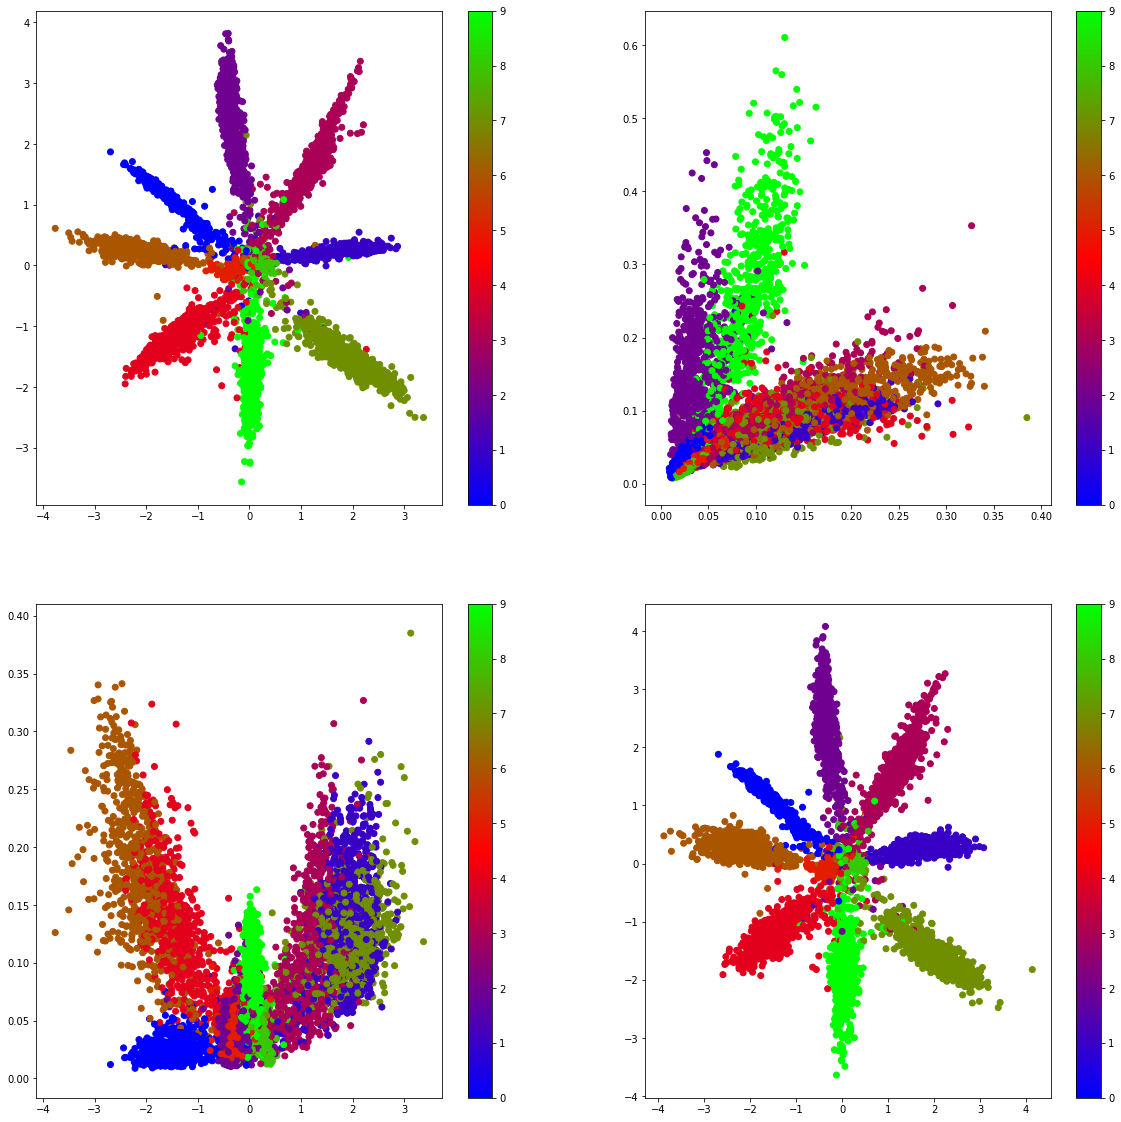

In [21]:
plot_2d_latent_space(model_unsupervised, mnist_onehot_encoder, mnist_test, mnist_labels_test)

In [129]:
def get_latent_space(train_data, train_labels, test_data, test_labels, encoder, omega,mixture_assignments_train,mixture_assignments_test):
    log_folder = log.get_log_folder()
    print('Starting autoencoder. Log folder={}'.format(log_folder))
    K=train_labels.shape[1]
    init_cov = np.array([
        [0.007,0.0],
        [0.0,0.0007]
    ], dtype="float64")

    betas = np.ones(K)/K


    model = StochasticNNWithGmm(
        x_dim=train_data.shape[1],
        y_dim=train_labels.shape[1],
        hidden_dims=[512, 256, 128, 2],
        log_folder=log_folder,
        alpha=0,
        beta=0,#0.1,
        gamma=1,
        omega=omega,
        r=2.0,
        K=K,
        init_cov=init_cov,
        is_latent_supervised=True,
        mixture_weights=betas
    )
    model.fit(
        X_train=train_data, 
        y_train=train_labels, 
        X_test=test_data,
        y_test=test_labels,
        mixture_assignments_train=mixture_assignments_train,
        mixture_assignments_test=mixture_assignments_test,
        epochs=5,
        log_interval=10
    )

    train_encoded = model.sampleLatent(train_data)
    test_encoded = model.sampleLatent(test_data)
    test_decoded_labels = encoder.inverse_transform(test_labels).reshape(-1)
    train_decoded_labels = encoder.inverse_transform(train_labels).reshape(-1)
    return test_encoded, test_decoded_labels, train_encoded, train_decoded_labels


Starting autoencoder. Log folder=/tmp/class_vae/deep/17_05_2019/20190517141553
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 2]
self.y.shape [None, 2]
xy.shape [None, 1292]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 8
epoch: 0
Train accuracy 0.5916230082511902
Test accuracy 0.625
epoch: 1
Train accuracy 0.7312390804290771
Test accuracy 0.625
epoch: 2
Train accuracy 0.9301919937133789
Test accuracy 0.699999988079071
epoch: 3
Train accuracy 0.9790576100349426
Test accuracy 0.7250000238418579
epoch: 4
Train accuracy 0.9877836108207703
Test accuracy 0.7099999785423279


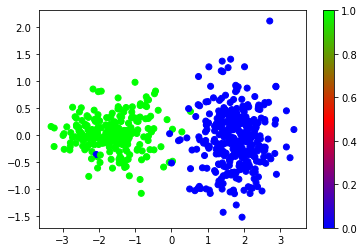

In [132]:
poliblog_test_latent_space, poliblog_test_decoded_labels, poliblog_train_latent_space, poliblog_train_decoded_labels = get_latent_space(
    train_data=poliblog_data_train_perm, 
    train_labels=poliblog_ratings_train_one_hot_perm, 
    test_data=poliblog_data_test, 
    test_labels=poliblog_ratings_test_one_hot, 
    encoder=poliblog_onehot_encoder,
    omega=1.0,
    mixture_assignments_train=poliblog_ratings_train_one_hot_perm,
    mixture_assignments_test=poliblog_ratings_test_one_hot
)
plt.scatter(poliblog_train_latent_space[:,0],poliblog_train_latent_space[:,1], c=poliblog_train_decoded_labels, cmap='brg')
plt.colorbar()


Starting autoencoder. Log folder=/tmp/class_vae/deep/25_05_2019/20190525205142
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 2]
self.y.shape [None, 2]
xy.shape [None, 18]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 11
epoch: 0
Train accuracy 0.7237196564674377
Test accuracy 0.7099999785423279
epoch: 1
Train accuracy 0.7237196564674377
Test accuracy 0.7099999785423279
epoch: 2
Train accuracy 0.8140161633491516
Test accuracy 0.8050000071525574
epoch: 3
Train accuracy 0.8544474244117737
Test accuracy 0.8600000143051147
epoch: 4
Train accuracy 0.8867924809455872
Test accuracy 0.8500000238418579


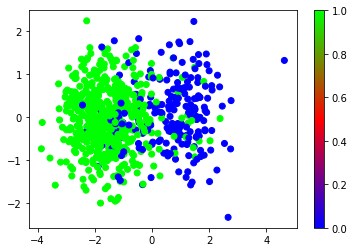

In [145]:
smsSpam_test_latent_space, smsSpam_test_decoded_labels, smsSpam_train_latent_space, smsSpam_train_decoded_labels = get_latent_space(
    train_data=smsSpam_data_train_perm, 
    train_labels=smsSpam_labels_train_one_hot_perm, 
    test_data=smsSpam_data_test, 
    test_labels=smsSpam_labels_test_one_hot, 
    encoder=smsSpam_onehot_encoder,
    omega=1.0,
    mixture_assignments_train=smsSpam_labels_train_one_hot_perm,
    mixture_assignments_test=smsSpam_labels_test_one_hot
)
plt.scatter(smsSpam_train_latent_space[:,0],smsSpam_train_latent_space[:,1], c=smsSpam_train_decoded_labels, cmap='brg')
plt.colorbar()

Starting autoencoder. Log folder=/tmp/class_vae/deep/17_05_2019/20190517141611
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 2]
self.y.shape [None, 2]
xy.shape [None, 2002]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 16
epoch: 0
Train accuracy 0.969924807548523
Test accuracy 0.9209039807319641
epoch: 1
Train accuracy 0.9859022498130798
Test accuracy 0.9477401375770569
epoch: 2
Train accuracy 0.9981203079223633
Test accuracy 0.944915235042572
epoch: 3
Train accuracy 0.9943609237670898
Test accuracy 0.9420903921127319
epoch: 4
Train accuracy 1.0
Test accuracy 0.9477401375770569


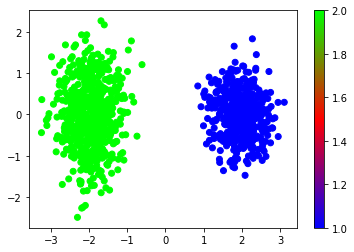

In [134]:
reuters2_test_latent_space, reuters2_test_decoded_labels, reuters2_train_latent_space, reuters2_train_decoded_labels = get_latent_space(
    train_data=reuters2_data_train_perm, 
    train_labels=reuters2_labels_train_one_hot_perm, 
    test_data=reuters2_data_test, 
    test_labels=reuters2_labels_test_one_hot, 
    encoder=reuters2_onehot_encoder,
    omega=1.0,
    mixture_assignments_train=reuters2_labels_train_one_hot_perm,
    mixture_assignments_test=reuters2_labels_test_one_hot
)
plt.scatter(reuters2_train_latent_space[:,0],reuters2_train_latent_space[:,1], c=reuters2_train_decoded_labels, cmap='brg')
plt.colorbar()

Starting autoencoder. Log folder=/tmp/class_vae/deep/17_05_2019/20190517141620
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 3]
self.y.shape [None, 3]
xy.shape [None, 2003]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 25
epoch: 0
Train accuracy 0.6743202209472656
Test accuracy 0.630671501159668
epoch: 1
Train accuracy 0.9287009239196777
Test accuracy 0.7622504830360413
epoch: 2
Train accuracy 0.9897280931472778
Test accuracy 0.8275862336158752
epoch: 3
Train accuracy 0.9969788789749146
Test accuracy 0.836660623550415
epoch: 4
Train accuracy 0.9975830912590027
Test accuracy 0.8393829464912415


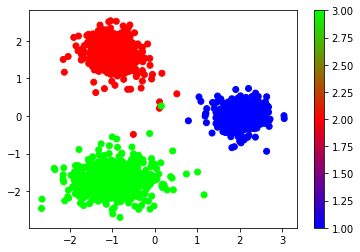

In [135]:
reuters3_test_latent_space, reuters3_test_decoded_labels, reuters3_train_latent_space, reuters3_train_decoded_labels = get_latent_space(
    train_data=reuters3_data_train_perm, 
    train_labels=reuters3_labels_train_one_hot_perm, 
    test_data=reuters3_data_test, 
    test_labels=reuters3_labels_test_one_hot, 
    encoder=reuters3_onehot_encoder,
    omega=1.0,
    mixture_assignments_train=reuters3_labels_train_one_hot_perm,
    mixture_assignments_test=reuters3_labels_test_one_hot
)
plt.scatter(reuters3_train_latent_space[:,0],reuters3_train_latent_space[:,1], c=reuters3_train_decoded_labels, cmap='brg')
plt.colorbar()

Starting autoencoder. Log folder=/tmp/class_vae/deep/17_05_2019/20190517141632
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 5]
self.y.shape [None, 5]
xy.shape [None, 2005]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 44
epoch: 0
Train accuracy 0.5309953689575195
Test accuracy 0.43374136090278625
epoch: 1
Train accuracy 0.8324477672576904
Test accuracy 0.6189462542533875
epoch: 2
Train accuracy 0.9645767211914062
Test accuracy 0.7126131057739258
epoch: 3
Train accuracy 0.9833510518074036
Test accuracy 0.7328366041183472
epoch: 4
Train accuracy 0.9918526411056519
Test accuracy 0.7498669624328613


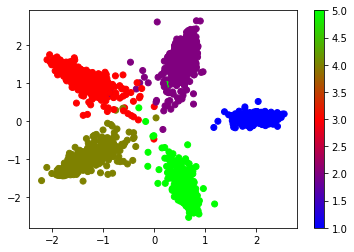

In [136]:
reuters5_test_latent_space, reuters5_test_decoded_labels, reuters5_train_latent_space, reuters5_train_decoded_labels = get_latent_space(
    train_data=reuters5_data_train_perm, 
    train_labels=reuters5_labels_train_one_hot_perm, 
    test_data=reuters5_data_test, 
    test_labels=reuters5_labels_test_one_hot, 
    encoder=reuters5_onehot_encoder,
    omega=1.0,
    mixture_assignments_train=reuters5_labels_train_one_hot_perm,
    mixture_assignments_test=reuters5_labels_test_one_hot
)
plt.scatter(reuters5_train_latent_space[:,0],reuters5_train_latent_space[:,1], c=reuters5_train_decoded_labels, cmap='brg')
plt.colorbar()

Starting autoencoder. Log folder=/tmp/class_vae/deep/17_05_2019/20190517140941
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 10]
self.y.shape [None, 10]
xy.shape [None, 794]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 984
epoch: 0
Train accuracy 0.9511111378669739
Test accuracy 0.9428571462631226
epoch: 1
Train accuracy 0.9643650650978088
Test accuracy 0.954285740852356
epoch: 2
Train accuracy 0.9695714116096497
Test accuracy 0.9574285745620728
epoch: 3
Train accuracy 0.9760317206382751
Test accuracy 0.9589999914169312
epoch: 4
Train accuracy 0.9824761748313904
Test accuracy 0.9642857313156128


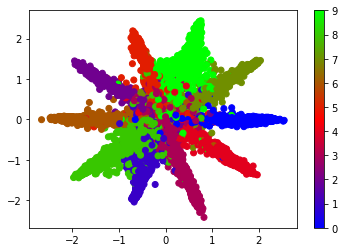

In [130]:
label_mapping = {
    0: 0,
    1: 7,
    2: 4,
    3: 8,
    4: 9,
    5: 3,
    6: 5,
    7: 1,
    8: 6,
    9: 2
}

mixture_assignments_train = create_mixture_assignments(
    label_mapping=label_mapping, 
    onehot_encoder=mnist_onehot_encoder, 
    y_train=mnist_labels_train_perm)

mixture_assignments_test = create_mixture_assignments(
    label_mapping=label_mapping, 
    onehot_encoder=mnist_onehot_encoder, 
    y_train=mnist_labels_test)

mnist_test_latent_space, mnist_test_decoded_labels,mnist_train_latent_space, mnist_train_decoded_labels = get_latent_space(
    train_data=mnist_train_perm, 
    train_labels=mnist_labels_train_perm, 
    test_data=mnist_test, 
    test_labels=mnist_labels_test, 
    encoder=mnist_onehot_encoder,
    omega=1.0,
    mixture_assignments_train=mixture_assignments_train,
    mixture_assignments_test=mixture_assignments_test,
)
plt.scatter(mnist_train_latent_space[:,0],mnist_train_latent_space[:,1], c=mnist_train_decoded_labels, cmap='brg')
plt.colorbar()

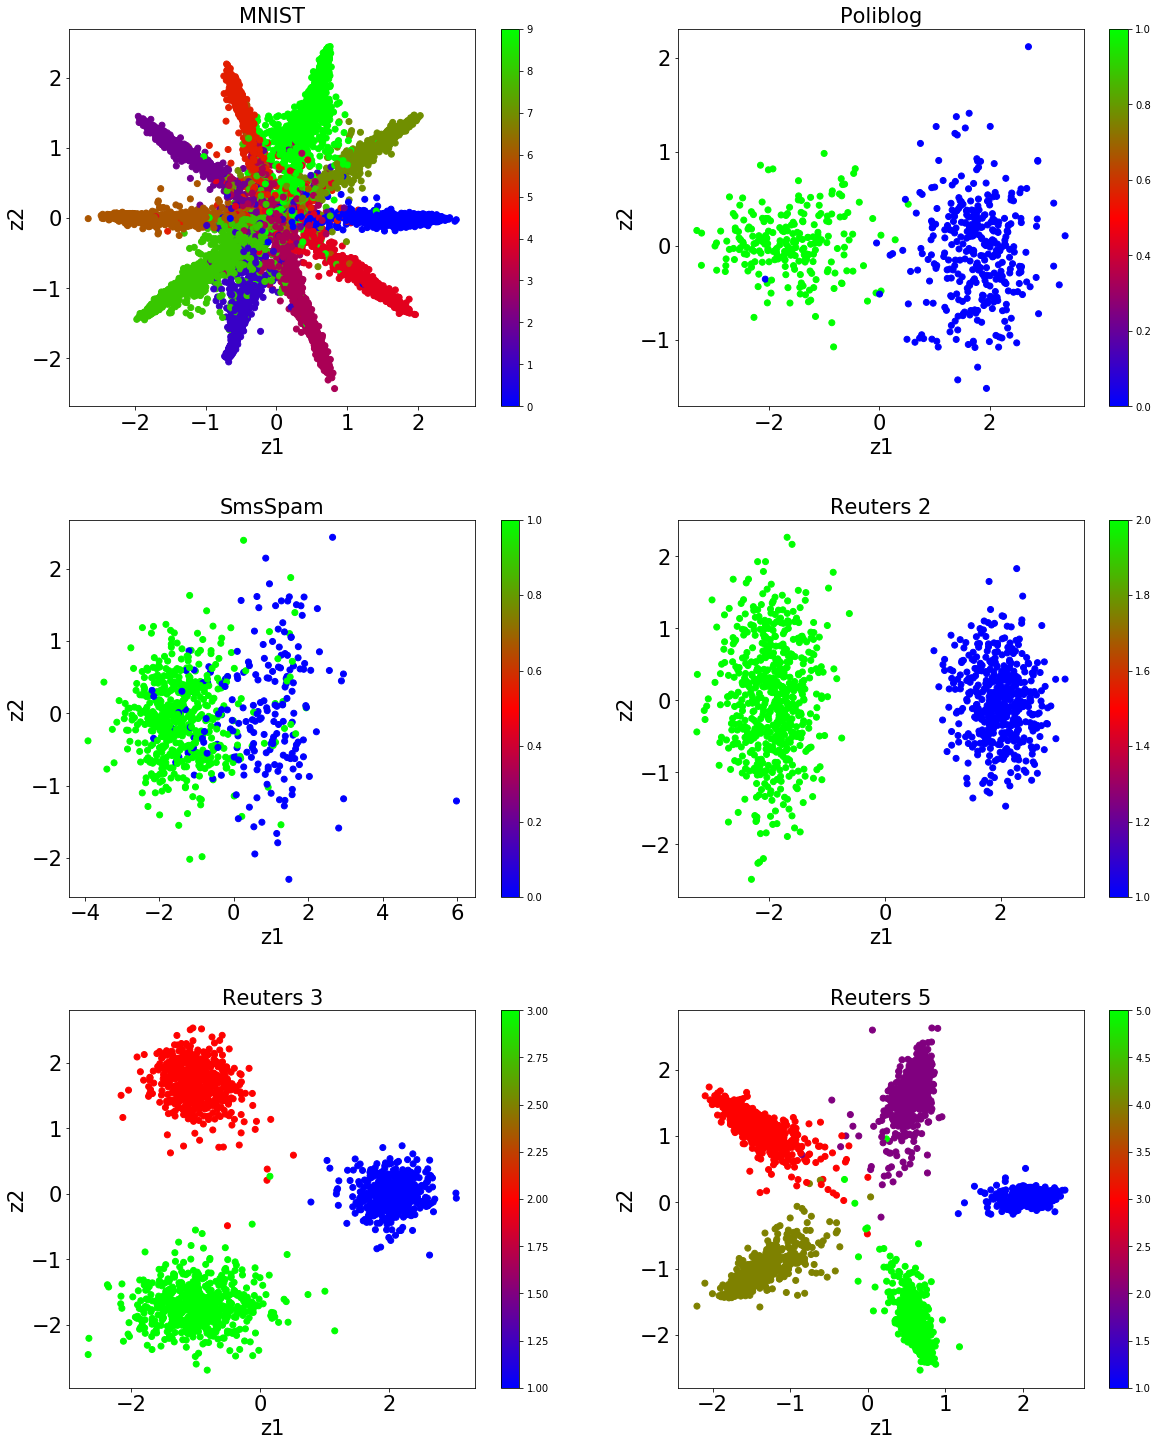

In [140]:
fig = plt.figure(figsize=(20, 25))
plt.subplots_adjust(hspace=0.3)

plt.subplot(3, 2, 1)
plt.scatter(mnist_train_latent_space[:,0],mnist_train_latent_space[:,1], c=mnist_train_decoded_labels, cmap='brg')
plt.colorbar()

plt.title("MNIST",fontsize=21)
plt.xlabel("z1",fontsize=21)
plt.ylabel("z2",fontsize=21)
plt.tick_params(axis='both', which='major', labelsize=21)

plt.subplot(3, 2, 2)
plt.scatter(poliblog_train_latent_space[:,0],poliblog_train_latent_space[:,1], c=poliblog_train_decoded_labels, cmap='brg')
plt.colorbar()

plt.title("Poliblog",fontsize=21)
plt.xlabel("z1",fontsize=21)
plt.ylabel("z2",fontsize=21)
plt.tick_params(axis='both', which='major', labelsize=21)

plt.subplot(3, 2, 3)
plt.scatter(smsSpam_train_latent_space[:,0],smsSpam_train_latent_space[:,1], c=smsSpam_train_decoded_labels, cmap='brg')
plt.colorbar()

plt.title("SmsSpam",fontsize=21)
plt.xlabel("z1",fontsize=21)
plt.ylabel("z2",fontsize=21)
plt.tick_params(axis='both', which='major', labelsize=21)

plt.subplot(3, 2, 4)
plt.scatter(reuters2_train_latent_space[:,0],reuters2_train_latent_space[:,1], c=reuters2_train_decoded_labels, cmap='brg')
plt.colorbar()

plt.title("Reuters 2",fontsize=21)
plt.xlabel("z1",fontsize=21)
plt.ylabel("z2",fontsize=21)
plt.tick_params(axis='both', which='major', labelsize=21)

plt.subplot(3, 2, 5)
plt.scatter(reuters3_train_latent_space[:,0],reuters3_train_latent_space[:,1], c=reuters3_train_decoded_labels, cmap='brg')
plt.colorbar()

plt.title("Reuters 3",fontsize=21)
plt.xlabel("z1",fontsize=21)
plt.ylabel("z2",fontsize=21)
plt.tick_params(axis='both', which='major', labelsize=21)

plt.subplot(3, 2, 6)
plt.scatter(reuters5_train_latent_space[:,0],reuters5_train_latent_space[:,1], c=reuters5_train_decoded_labels, cmap='brg')
plt.colorbar()

plt.title("Reuters 5",fontsize=21)
plt.xlabel("z1",fontsize=21)
plt.ylabel("z2",fontsize=21)
plt.tick_params(axis='both', which='major', labelsize=21)

plt.savefig('/Users/mjankowski/Desktop/gaussian_dnn__sup_latent_space.png', bbox_inches='tight')
plt.show()

In [ ]:
MNIST

RF
- unsupervised vae                              : 0.81
- supervised VAE                                :
- unsupervised latent space with prior          :
- supervised latent space without prior         : 
- supervised latent space with prior            : 0.962

DT
- unsupervised vae                              : 0.86
- supervised VAE                                :
- unsupervised latent space with prior          :
- supervised latent space without prior         :
- supervised latent space with prior            : 0.954

NN
- unsupervised vae                              : 0.93 (dim 30)
- supervised VAE                                :
- unsupervised latent space with prior          :
- supervised latent space without prior         :
- supervised latent space with prior            : 0.96

NB
- unsupervised vae                              : 0.86
- supervised VAE                                :
- unsupervised latent space with prior          :
- supervised latent space without prior         :
- supervised latent space with prior            : 0.95


x five algorithms (RF, DT, NN, NB, decoder)

In [125]:
def compare_vae_svae_and_dslgmm(dataset_name, orig_results, vae_results, svae_results, dslgmm_results, bottom):
    
    orig_results_shifted = np.array(orig_results)-bottom
    vae_results_shifted = np.array(vae_results)-bottom
    svae_results_shifted = np.array(svae_results)-bottom
    dslgmm_results_shifted = np.array(dslgmm_results)-bottom
    
    ind=np.arange(5)
    width=0.17
    dim_red=['VAE','SVAE','DSLGMM','Original (all features)']

#     x_labels = ['Random Forest', 'Decision Tree', 'Neural Network', 'Naive Bayes', 'Embedded']
    x_labels = ['RF', 'DT', 'NN', 'NB', 'Embedded']
    plt.bar(ind, vae_results_shifted, width, label='VAE', bottom=bottom)
    plt.bar(ind + 1*width, svae_results_shifted, width, label='SVAE', bottom=bottom)
    plt.bar(ind + 2*width, dslgmm_results_shifted, width, label='Supervised Latent Space', bottom=bottom)
    plt.bar(ind + 3*width, orig_results_shifted, width, label='Original', bottom=bottom)

    

    plt.xticks(ind+0.2, x_labels, fontsize=21)
    plt.xlabel('Algorithm', fontsize=21)
    plt.ylabel('Accuracy', fontsize=21)
#     plt.title("Comparison of VAE, SVAE and DSLGMM results for {}".format(dataset_name),fontsize=21)
    plt.title("{}".format(dataset_name),fontsize=21)

    plt.legend(dim_red,loc='upper center', bbox_to_anchor=(0.5,-0.2))



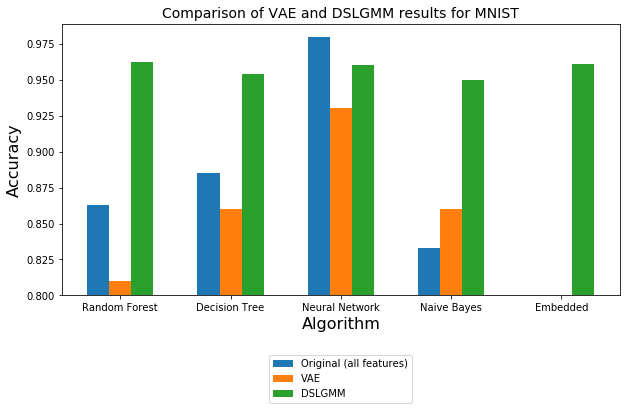

In [218]:
mnist_bottom=0.8
mnist_vae = [0.81, 0.86, 0.93, 0.86, mnist_bottom]
mnist_best = [0.962, 0.954, 0.96, 0.95, 0.961]
mnist_orig=[0.863,0.885,0.98,0.833,mnist_bottom]
compare_vae_and_dslgmm('MNIST', mnist_orig, mnist_vae, mnist_best, bottom=mnist_bottom)

In [219]:
def analyse_for_dataset(
    train_dataset, 
    test_dataset, 
    train_labels, 
    train_labels_integer, 
    test_labels,
    test_labels_integer):
    
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
    model.fit(train_dataset, train_labels_integer)
    
    test_prediction = model.predict(test_dataset)
    rf_acc = accuracy_score(y_pred=test_prediction, y_true=test_labels_integer)
    print("RF {}".format(rf_acc))

    dt_model = DecisionTreeClassifier(random_state=0)
    dt_model.fit(train_dataset, train_labels_integer)
    dt_prediction = dt_model.predict(test_dataset)
    
    dt_acc = accuracy_score(y_pred=dt_prediction, y_true=test_labels_integer)
    print("RF {}".format(dt_acc))

    nb_model = BernoulliNB()
    nb_model.fit(train_dataset, train_labels_integer)
    
    nb_test_prediction = nb_model.predict(test_dataset)
    acc_naive_bayes = accuracy_score(y_pred=nb_test_prediction, y_true=test_labels_integer)
    print("NB {}".format(acc_naive_bayes))
    
    

In [221]:
analyse_for_dataset(
    train_dataset=mnist_train_perm, 
    test_dataset=mnist_test, 
    train_labels=mnist_labels_train_perm, 
    train_labels_integer=mnist_train_labels_integers, 
    test_labels=mnist_labels_test,
    test_labels_integer=mnist_test_labels_integers
)

RF 0.8637142857142858
RF 0.8851428571428571
0.8331428571428572


In [222]:
analyse_for_dataset(
    train_dataset=poliblog_data_train_perm, 
    test_dataset=poliblog_data_test, 
    train_labels=poliblog_ratings_train_one_hot_perm, 
    train_labels_integer=poliblog_train_labels_integers, 
    test_labels=poliblog_ratings_test_one_hot,
    test_labels_integer=poliblog_test_labels_integers
)

RF 0.71
RF 0.655
0.695


In [220]:
poliblog_accs_dsl_gmm

array([0.65 , 0.655, 0.66 , 0.65 , 0.75 ])

In [119]:
poliblog_accs_vae



[0.635, 0.585, 0.63, 0.625]

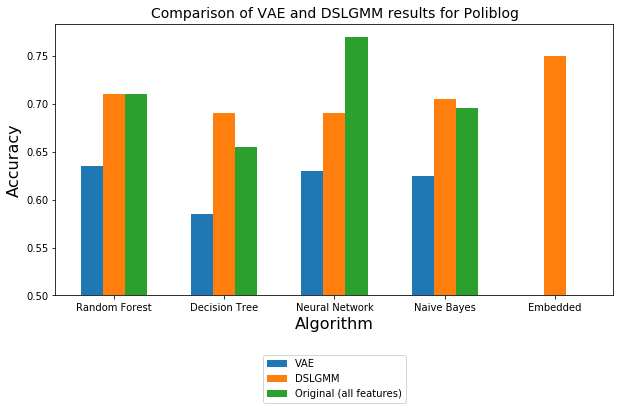

In [122]:
fig = plt.figure(figsize=(10, 5))

poliblog_bottom=0.5
poliblog_accs_vae = [0.635, 0.585, 0.63, 0.625,poliblog_bottom]

poliblog_accs_dsl_gmm = poliblog_accs
poliblog_accs_dsl_gmm = np.append(poliblog_accs_dsl_gmm, [0.75])
poliblog_orig=[0.71,0.655,0.77,0.695,poliblog_bottom]
compare_vae_and_dslgmm('Poliblog', poliblog_orig, poliblog_accs_vae, poliblog_accs_dsl_gmm, bottom=poliblog_bottom)

In [226]:
analyse_for_dataset(
    train_dataset=smsSpam_data_train_perm, 
    test_dataset=smsSpam_data_test, 
    train_labels=smsSpam_labels_train_one_hot_perm, 
    train_labels_integer=smsSpam_train_labels_integers, 
    test_labels=smsSpam_labels_test_one_hot,
    test_labels_integer=smsSpam_test_labels_integers
)

RF 0.83
RF 0.895
0.83


In [146]:
smsSpam_acc_dslgmm

[0.87, 0.795, 0.87, 0.88, 0.879]

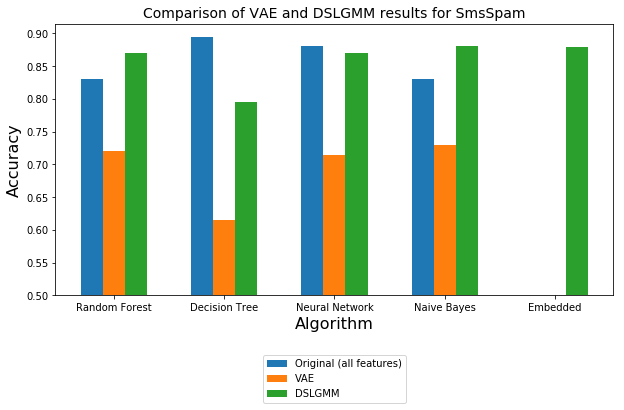

In [251]:
fig = plt.figure(figsize=(10, 5))

smsSpam_bottom=0.5
smsSpam_acc_dslgmm 
smsSpam_acc_vae = [0.72, 0.615, 0.715, 0.73, smsSpam_bottom]
smsSpam_orig=[0.83,0.895,0.88,0.83,smsSpam_bottom]
compare_vae_and_dslgmm('SmsSpam', smsSpam_orig, smsSpam_acc_vae, smsSpam_acc_dslgmm, bottom=smsSpam_bottom)




In [229]:
analyse_for_dataset(
    train_dataset=reuters2_data_train_perm, 
    test_dataset=reuters2_data_test, 
    train_labels=reuters2_labels_train_one_hot_perm, 
    train_labels_integer=reuters2_train_labels_integers, 
    test_labels=reuters2_labels_test_one_hot,
    test_labels_integer=reuters2_test_labels_integers
)

RF 0.8997175141242938
RF 0.8968926553672316
0.9067796610169492


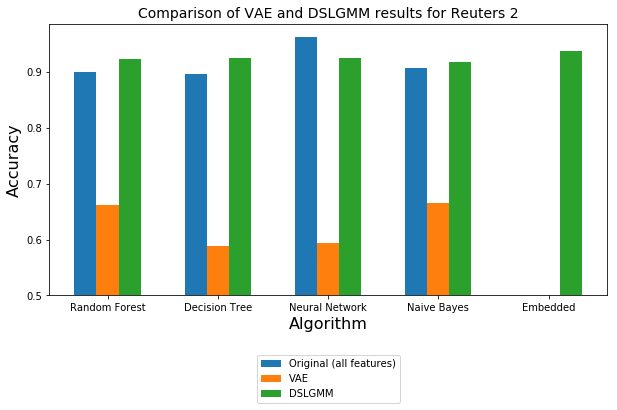

In [252]:
fig = plt.figure(figsize=(10, 5))

reuters2_bottom=0.5
reuters2_acc_dslgmm=[0.923, 0.925, 0.925, 0.918, 0.937]
reuters2_acc_vae = [0.662, 0.588, 0.593, 0.665, reuters2_bottom]
reuters2_orig=[0.899,0.896,0.963,0.906,reuters2_bottom]
compare_vae_and_dslgmm('Reuters 2', reuters2_orig, reuters2_acc_vae, reuters2_acc_dslgmm, bottom=reuters2_bottom)

In [232]:
analyse_for_dataset(
    train_dataset=reuters3_data_train_perm, 
    test_dataset=reuters3_data_test, 
    train_labels=reuters3_labels_train_one_hot_perm, 
    train_labels_integer=reuters3_train_labels_integers, 
    test_labels=reuters3_labels_test_one_hot,
    test_labels_integer=reuters3_test_labels_integers
)

RF 0.8448275862068966
RF 0.809437386569873
0.8185117967332124


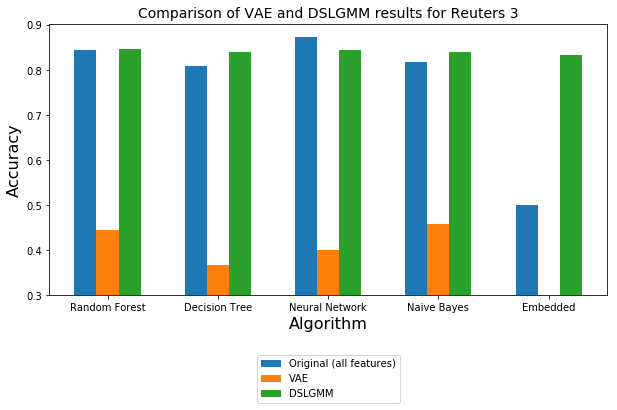

In [253]:
fig = plt.figure(figsize=(10, 5))

reuters3_bottom=0.3
reuters3_acc_dslgmm=[0.846,0.839,0.844,0.84,0.833]
reuters3_acc_vae = [0.445, 0.368, 0.400, 0.458, reuters3_bottom]
reuters3_orig=[0.844,0.809,0.874,0.818,reuters2_bottom]
compare_vae_and_dslgmm('Reuters 3', reuters3_orig, reuters3_acc_vae, reuters3_acc_dslgmm, bottom=reuters3_bottom)




In [235]:
analyse_for_dataset(
    train_dataset=reuters5_data_train_perm, 
    test_dataset=reuters5_data_test, 
    train_labels=reuters5_labels_train_one_hot_perm, 
    train_labels_integer=reuters5_train_labels_integers, 
    test_labels=reuters5_labels_test_one_hot,
    test_labels_integer=reuters5_test_labels_integers
)

RF 0.739755188930282
RF 0.6492815327301756
0.7333688131985099


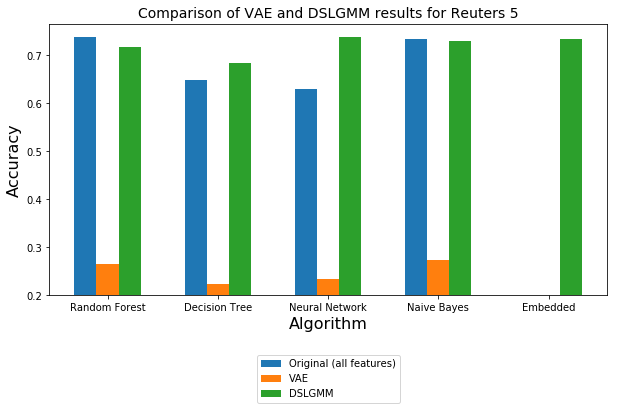

In [254]:
fig = plt.figure(figsize=(10, 5))

reuters5_bottom=0.2
reuters5_acc_dslgmm=[0.718,0.684,0.739,0.729,0.733]
reuters5_acc_vae = [0.265, 0.224, 0.235, 0.273, reuters5_bottom]
reuters5_orig=[0.739,0.649,0.630,0.733,reuters5_bottom]
compare_vae_and_dslgmm('Reuters 5', reuters5_orig, reuters5_acc_vae, reuters5_acc_dslgmm, bottom=reuters5_bottom)

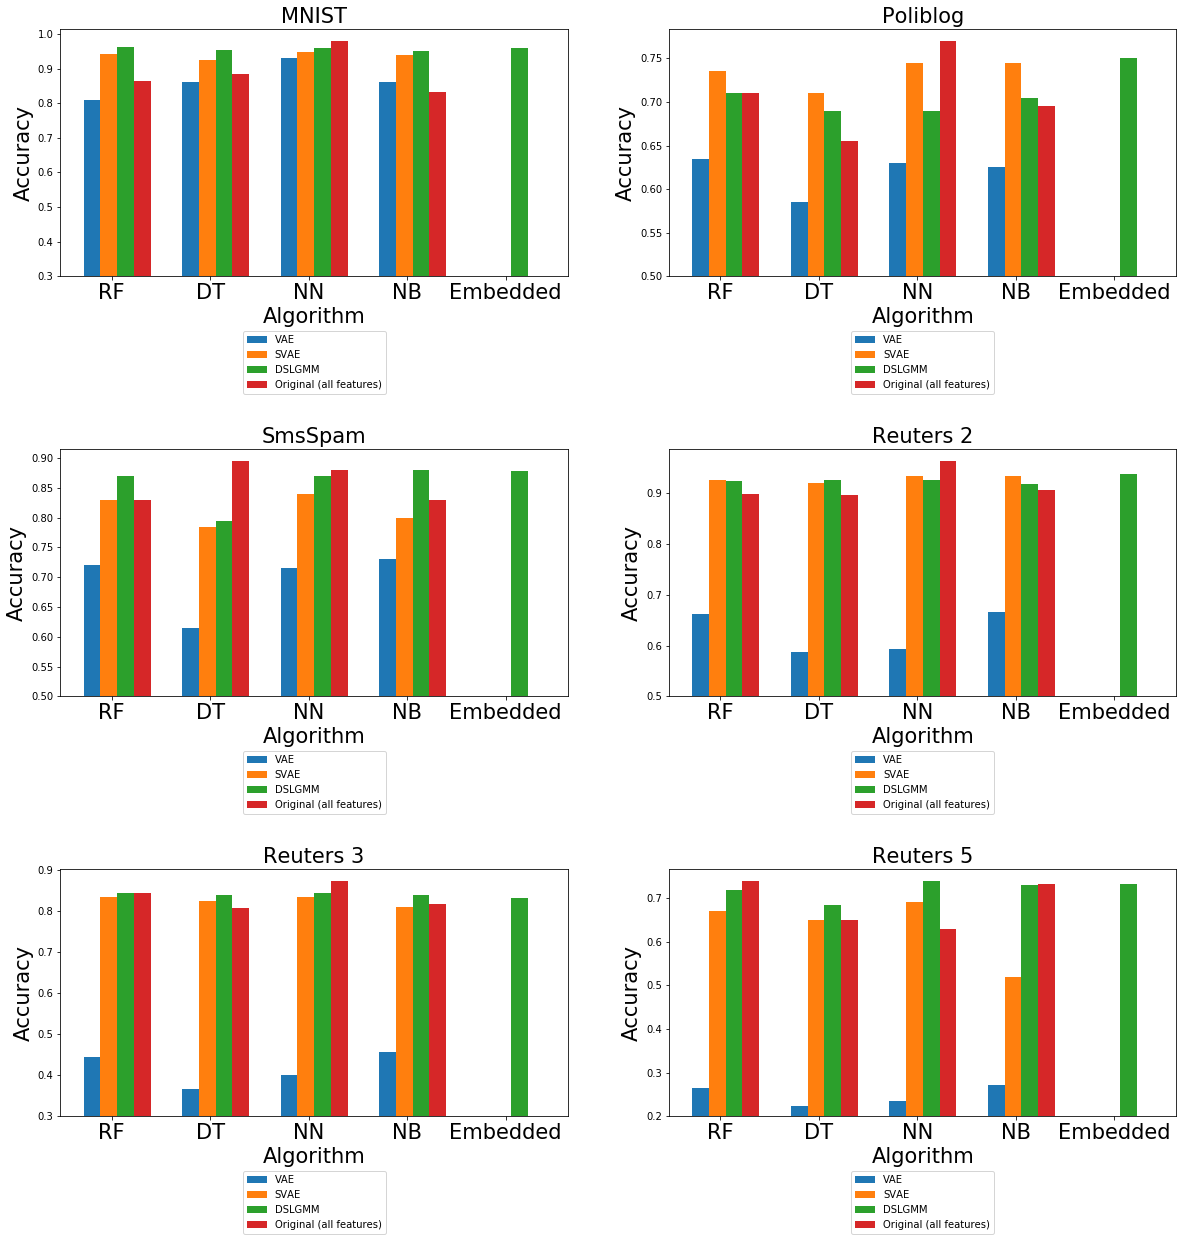

In [126]:
fig = plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.7)

plt.subplot(3, 2, 1)
mnist_bottom=0.3
mnist_vae = [0.81, 0.86, 0.93, 0.86, mnist_bottom]
mnist_dslgmm = [0.962, 0.954, 0.96, 0.95, 0.961]
mnist_orig=[0.863,0.885,0.98,0.833,mnist_bottom]
mnist_svae = [0.942,0.924,0.948,0.94,mnist_bottom]
compare_vae_svae_and_dslgmm('MNIST', mnist_orig, mnist_vae, mnist_svae, mnist_dslgmm, bottom=mnist_bottom)

plt.subplot(3, 2, 2)
poliblog_bottom=0.5
poliblog_accs_vae = [0.635, 0.585, 0.63, 0.625,poliblog_bottom]
poliblog_accs_dsl_gmm = poliblog_accs
poliblog_accs_dsl_gmm = np.append(poliblog_accs_dsl_gmm, [0.75])
poliblog_orig=[0.71,0.655,0.77,0.695,poliblog_bottom]
poliblog_svae = [0.735,0.71,0.745,0.745,poliblog_bottom]
compare_vae_svae_and_dslgmm('Poliblog', poliblog_orig, poliblog_accs_vae, poliblog_svae, poliblog_accs_dsl_gmm, bottom=poliblog_bottom)

plt.subplot(3, 2, 3)
smsSpam_bottom=0.5
smsSpam_acc_dslgmm 
smsSpam_acc_vae = [0.72, 0.615, 0.715, 0.73, smsSpam_bottom]
smsSpam_orig=[0.83,0.895,0.88,0.83,smsSpam_bottom]
sms_spam_svae = [0.83,0.785,0.84,0.8,smsSpam_bottom]
compare_vae_svae_and_dslgmm('SmsSpam', smsSpam_orig, smsSpam_acc_vae, sms_spam_svae, smsSpam_acc_dslgmm, bottom=smsSpam_bottom)

plt.subplot(3, 2, 4)
reuters2_bottom=0.5
reuters2_acc_dslgmm=[0.923, 0.925, 0.925, 0.918, 0.937]
reuters2_acc_vae = [0.662, 0.588, 0.593, 0.665, reuters2_bottom]
reuters2_orig=[0.899,0.896,0.963,0.906,reuters2_bottom]
reuters2_svae = [0.925,0.919,0.933,0.933,reuters2_bottom]
compare_vae_svae_and_dslgmm('Reuters 2', reuters2_orig, reuters2_acc_vae, reuters2_svae, reuters2_acc_dslgmm, bottom=reuters2_bottom)

plt.subplot(3, 2, 5)
reuters3_bottom=0.3
reuters3_acc_dslgmm=[0.846,0.839,0.844,0.84,0.833]
reuters3_acc_vae = [0.445, 0.368, 0.400, 0.458, reuters3_bottom]
reuters3_orig=[0.844,0.809,0.874,0.818,reuters3_bottom]
reuters3_svae = [0.834,0.825,0.835,0.811,reuters3_bottom]
compare_vae_svae_and_dslgmm('Reuters 3', reuters3_orig, reuters3_acc_vae, reuters3_svae, reuters3_acc_dslgmm, bottom=reuters3_bottom)


plt.subplot(3, 2, 6)
reuters5_bottom=0.2
reuters5_acc_dslgmm=[0.718,0.684,0.739,0.729,0.733]
reuters5_acc_vae = [0.265, 0.224, 0.235, 0.273, reuters5_bottom]
reuters5_orig=[0.739,0.649,0.630,0.733,reuters5_bottom]
reuters5_svae = [0.671,0.650,0.69,0.52,reuters5_bottom]
compare_vae_svae_and_dslgmm('Reuters 5', reuters5_orig, reuters5_acc_vae, reuters5_svae, reuters5_acc_dslgmm, bottom=reuters5_bottom)

plt.savefig('/Users/mjankowski/Desktop/compare_vae_and_dslgmm.png', bbox_inches='tight')
plt.show()

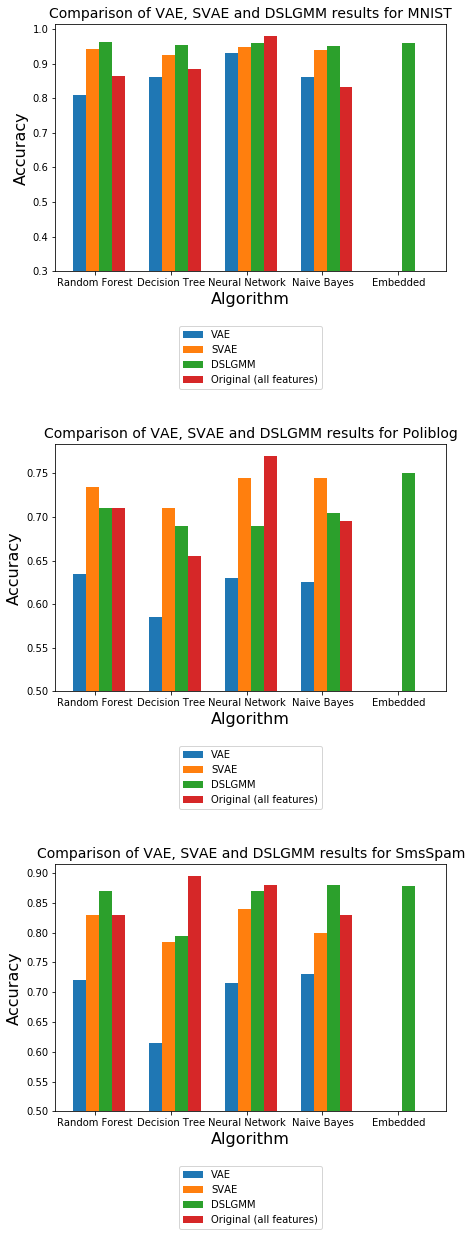

In [115]:
fig = plt.figure(figsize=(7, 20))
plt.subplots_adjust(hspace=0.7)

plt.subplot(3, 1, 1)
mnist_bottom=0.3
mnist_vae = [0.81, 0.86, 0.93, 0.86, mnist_bottom]
mnist_dslgmm = [0.962, 0.954, 0.96, 0.95, 0.961]
mnist_orig=[0.863,0.885,0.98,0.833,mnist_bottom]
mnist_svae = [0.942,0.924,0.948,0.94,mnist_bottom]
compare_vae_svae_and_dslgmm('MNIST', mnist_orig, mnist_vae, mnist_svae, mnist_dslgmm, bottom=mnist_bottom)

plt.subplot(3, 1, 2)
poliblog_bottom=0.5
poliblog_accs_vae = [0.635, 0.585, 0.63, 0.625,poliblog_bottom]
poliblog_accs_dsl_gmm = poliblog_accs
poliblog_accs_dsl_gmm = np.append(poliblog_accs_dsl_gmm, [0.75])
poliblog_orig=[0.71,0.655,0.77,0.695,poliblog_bottom]
poliblog_svae = [0.735,0.71,0.745,0.745,poliblog_bottom]
compare_vae_svae_and_dslgmm('Poliblog', poliblog_orig, poliblog_accs_vae, poliblog_svae, poliblog_accs_dsl_gmm, bottom=poliblog_bottom)

plt.subplot(3, 1, 3)
smsSpam_bottom=0.5
smsSpam_acc_dslgmm 
smsSpam_acc_vae = [0.72, 0.615, 0.715, 0.73, smsSpam_bottom]
smsSpam_orig=[0.83,0.895,0.88,0.83,smsSpam_bottom]
sms_spam_svae = [0.83,0.785,0.84,0.8,smsSpam_bottom]
compare_vae_svae_and_dslgmm('SmsSpam', smsSpam_orig, smsSpam_acc_vae, sms_spam_svae, smsSpam_acc_dslgmm, bottom=smsSpam_bottom)

plt.savefig('/Users/mjankowski/Desktop/compare_vae_and_dslgmm_two_columns_1.png', bbox_inches='tight')
plt.show()

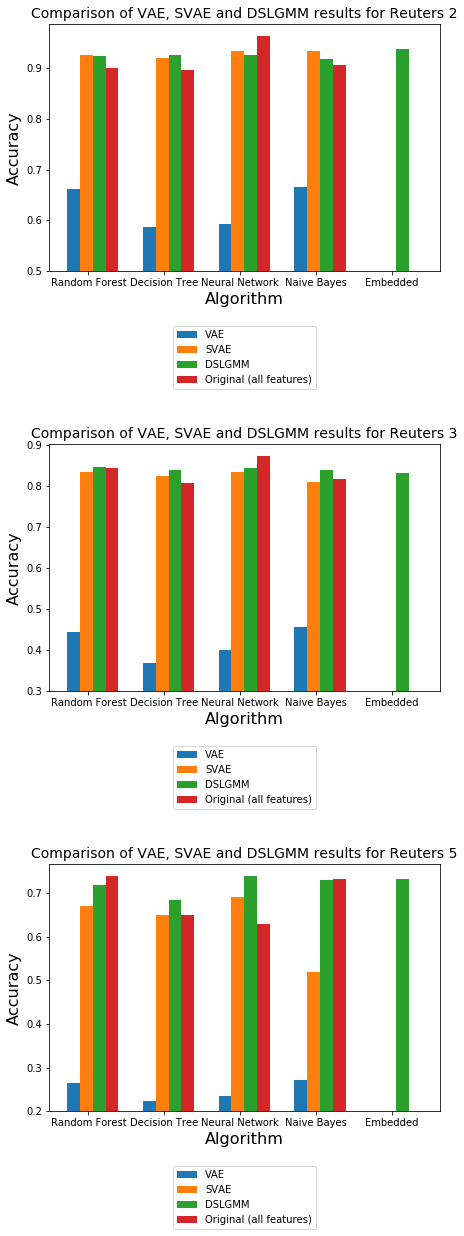

In [116]:
fig = plt.figure(figsize=(7, 20))
plt.subplots_adjust(hspace=0.7)


plt.subplot(3, 1, 1)
reuters2_bottom=0.5
reuters2_acc_dslgmm=[0.923, 0.925, 0.925, 0.918, 0.937]
reuters2_acc_vae = [0.662, 0.588, 0.593, 0.665, reuters2_bottom]
reuters2_orig=[0.899,0.896,0.963,0.906,reuters2_bottom]
reuters2_svae = [0.925,0.919,0.933,0.933,reuters2_bottom]
compare_vae_svae_and_dslgmm('Reuters 2', reuters2_orig, reuters2_acc_vae, reuters2_svae, reuters2_acc_dslgmm, bottom=reuters2_bottom)

plt.subplot(3, 1, 2)
reuters3_bottom=0.3
reuters3_acc_dslgmm=[0.846,0.839,0.844,0.84,0.833]
reuters3_acc_vae = [0.445, 0.368, 0.400, 0.458, reuters3_bottom]
reuters3_orig=[0.844,0.809,0.874,0.818,reuters3_bottom]
reuters3_svae = [0.834,0.825,0.835,0.811,reuters3_bottom]
compare_vae_svae_and_dslgmm('Reuters 3', reuters3_orig, reuters3_acc_vae, reuters3_svae, reuters3_acc_dslgmm, bottom=reuters3_bottom)


plt.subplot(3, 1, 3)
reuters5_bottom=0.2
reuters5_acc_dslgmm=[0.718,0.684,0.739,0.729,0.733]
reuters5_acc_vae = [0.265, 0.224, 0.235, 0.273, reuters5_bottom]
reuters5_orig=[0.739,0.649,0.630,0.733,reuters5_bottom]
reuters5_svae = [0.671,0.650,0.69,0.52,reuters5_bottom]
compare_vae_svae_and_dslgmm('Reuters 5', reuters5_orig, reuters5_acc_vae, reuters5_svae, reuters5_acc_dslgmm, bottom=reuters5_bottom)

plt.savefig('/Users/mjankowski/Desktop/compare_vae_and_dslgmm_two_columns_2.png', bbox_inches='tight')
plt.show()

In [150]:
1.0-0.879

0.121

In [149]:
poliblog_accs

array([0.71 , 0.69 , 0.69 , 0.705])

In [148]:
smsSpam_acc_dslgmm

[0.87, 0.795, 0.87, 0.88, 0.879]

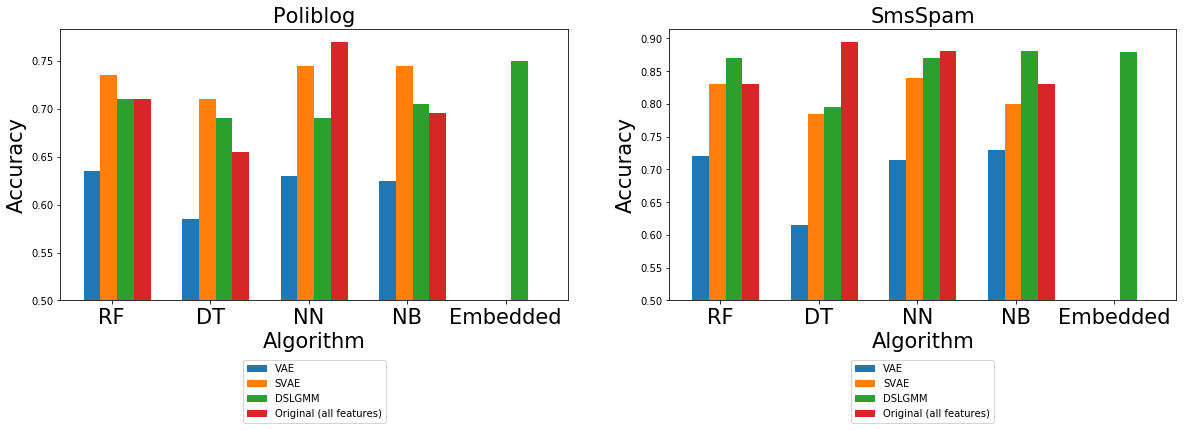

In [144]:
fig = plt.figure(figsize=(20, 5))
plt.subplots_adjust(hspace=0.7)


plt.subplot(1, 2, 1)
poliblog_bottom=0.5
poliblog_accs_vae = [0.635, 0.585, 0.63, 0.625,poliblog_bottom]
poliblog_accs_dsl_gmm = poliblog_accs
poliblog_accs_dsl_gmm = np.append(poliblog_accs_dsl_gmm, [0.75])
poliblog_orig=[0.71,0.655,0.77,0.695,poliblog_bottom]
poliblog_svae = [0.735,0.71,0.745,0.745,poliblog_bottom]
compare_vae_svae_and_dslgmm('Poliblog', poliblog_orig, poliblog_accs_vae, poliblog_svae, poliblog_accs_dsl_gmm, bottom=poliblog_bottom)

plt.subplot(1, 2, 2)
smsSpam_bottom=0.5
smsSpam_acc_dslgmm 
smsSpam_acc_vae = [0.72, 0.615, 0.715, 0.73, smsSpam_bottom]
smsSpam_orig=[0.83,0.895,0.88,0.83,smsSpam_bottom]
sms_spam_svae = [0.83,0.785,0.84,0.8,smsSpam_bottom]
compare_vae_svae_and_dslgmm('SmsSpam', smsSpam_orig, smsSpam_acc_vae, sms_spam_svae, smsSpam_acc_dslgmm, bottom=smsSpam_bottom)


# plt.savefig('/Users/mjankowski/Desktop/compare_vae_and_dslgmm.png', bbox_inches='tight')
plt.show()